# Importing Libraries

In [1]:
# pandas dataframe & numpy array manipulation library
import pandas as pd
import numpy as np

# data visualization library
import seaborn as sns
import matplotlib.pyplot as plt

# setting visualization parameters
sns.set_theme(style='darkgrid', palette='Set1')
plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['figure.dpi'] = 350

# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from kneed import KneeLocator
from yellowbrick.cluster import KElbowVisualizer

#### importing dataset

In [2]:
df = pd.read_csv('userbehaviour.csv')

df.head()

userid  Average Screen Time  Average Spent on App (INR)  Left Review  \
0    1001                 17.0                       634.0            1   
1    1002                  0.0                        54.0            0   
2    1003                 37.0                       207.0            0   
3    1004                 32.0                       445.0            1   
4    1005                 45.0                       427.0            1   

   Ratings  New Password Request  Last Visited Minutes       Status  
0        9                     7                  2990    Installed  
1        4                     8                 24008  Uninstalled  
2        8                     5                   971    Installed  
3        6                     2                   799    Installed  
4        5                     6                  3668    Installed

## Data Dictionary

userid: A unique identifier for each user.

Average Screen Time: The average amount of time, in minutes, that a user spends on the app.

Average Spent on App (INR): The average amount of money, in Indian Rupees (INR), spent by a user on the app.

Left Review: Binary variable indicating whether a user left a review (1) or not (0).

Ratings: The user ratings given for the app.

New Password Request: The number of times a user requested a new password.

Last Visited Minutes: The number of minutes since the user's last visit to the app.

Status: The current status of the user, whether they are "Installed" or "Uninstalled" the app.

# Exploratory Data Analysis

In [3]:
# checking basic information of all the features in dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   userid                      999 non-null    int64  
 1   Average Screen Time         999 non-null    float64
 2   Average Spent on App (INR)  999 non-null    float64
 3   Left Review                 999 non-null    int64  
 4   Ratings                     999 non-null    int64  
 5   New Password Request        999 non-null    int64  
 6   Last Visited Minutes        999 non-null    int64  
 7   Status                      999 non-null    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 62.6+ KB


In [4]:
# checking the number of rows(999) & columns(8)

df.shape

(999, 8)

In [5]:
# checking for null values

df.isna().sum()

userid                        0
Average Screen Time           0
Average Spent on App (INR)    0
Left Review                   0
Ratings                       0
New Password Request          0
Last Visited Minutes          0
Status                        0
dtype: int64

In [6]:
# checking for duplicated values

df.duplicated().sum()

0

- There are no mising values 
- there are no duplicated values

In [7]:
# getting the basic statistical information for numerical data

df.describe().T

count         mean          std     min     25%  \
userid                      999.0  1500.000000   288.530761  1001.0  1250.5   
Average Screen Time         999.0    24.390390    14.235415     0.0    12.0   
Average Spent on App (INR)  999.0   424.415415   312.365695     0.0    96.0   
Left Review                 999.0     0.497497     0.500244     0.0     0.0   
Ratings                     999.0     6.513514     2.701511     0.0     5.0   
New Password Request        999.0     4.941942     2.784626     1.0     3.0   
Last Visited Minutes        999.0  5110.898899  8592.036516   201.0  1495.5   

                               50%     75%      max  
userid                      1500.0  1749.5   1999.0  
Average Screen Time           24.0    36.0     50.0  
Average Spent on App (INR)   394.0   717.5    998.0  
Left Review                    0.0     1.0      1.0  
Ratings                        7.0     9.0     10.0  
New Password Request           5.0     7.0     15.0  
Last Visited Minutes        2865.0  4198.0  49715.0

In [8]:
# getting statistical informartion about categorical data

df.describe(include=object)

Status
count         999
unique          2
top     Installed
freq          916

In [9]:
# count of all the unique values in status feature

df['Status'].value_counts()

Installed      916
Uninstalled     83
Name: Status, dtype: int64

- **Average Screen Time** of a user - maximum 50, minimum 0 and average is 24 minutes
- **Average Spent on App (INR)** - average spent is of 424 rs, minimum of 0 & maximum of 998 rs
- **Rating** - ranges from 0 to 10
- **Status** - out 0f 999 users , 83 users dont have app installed where 916 users have the app installed

### Visualizations

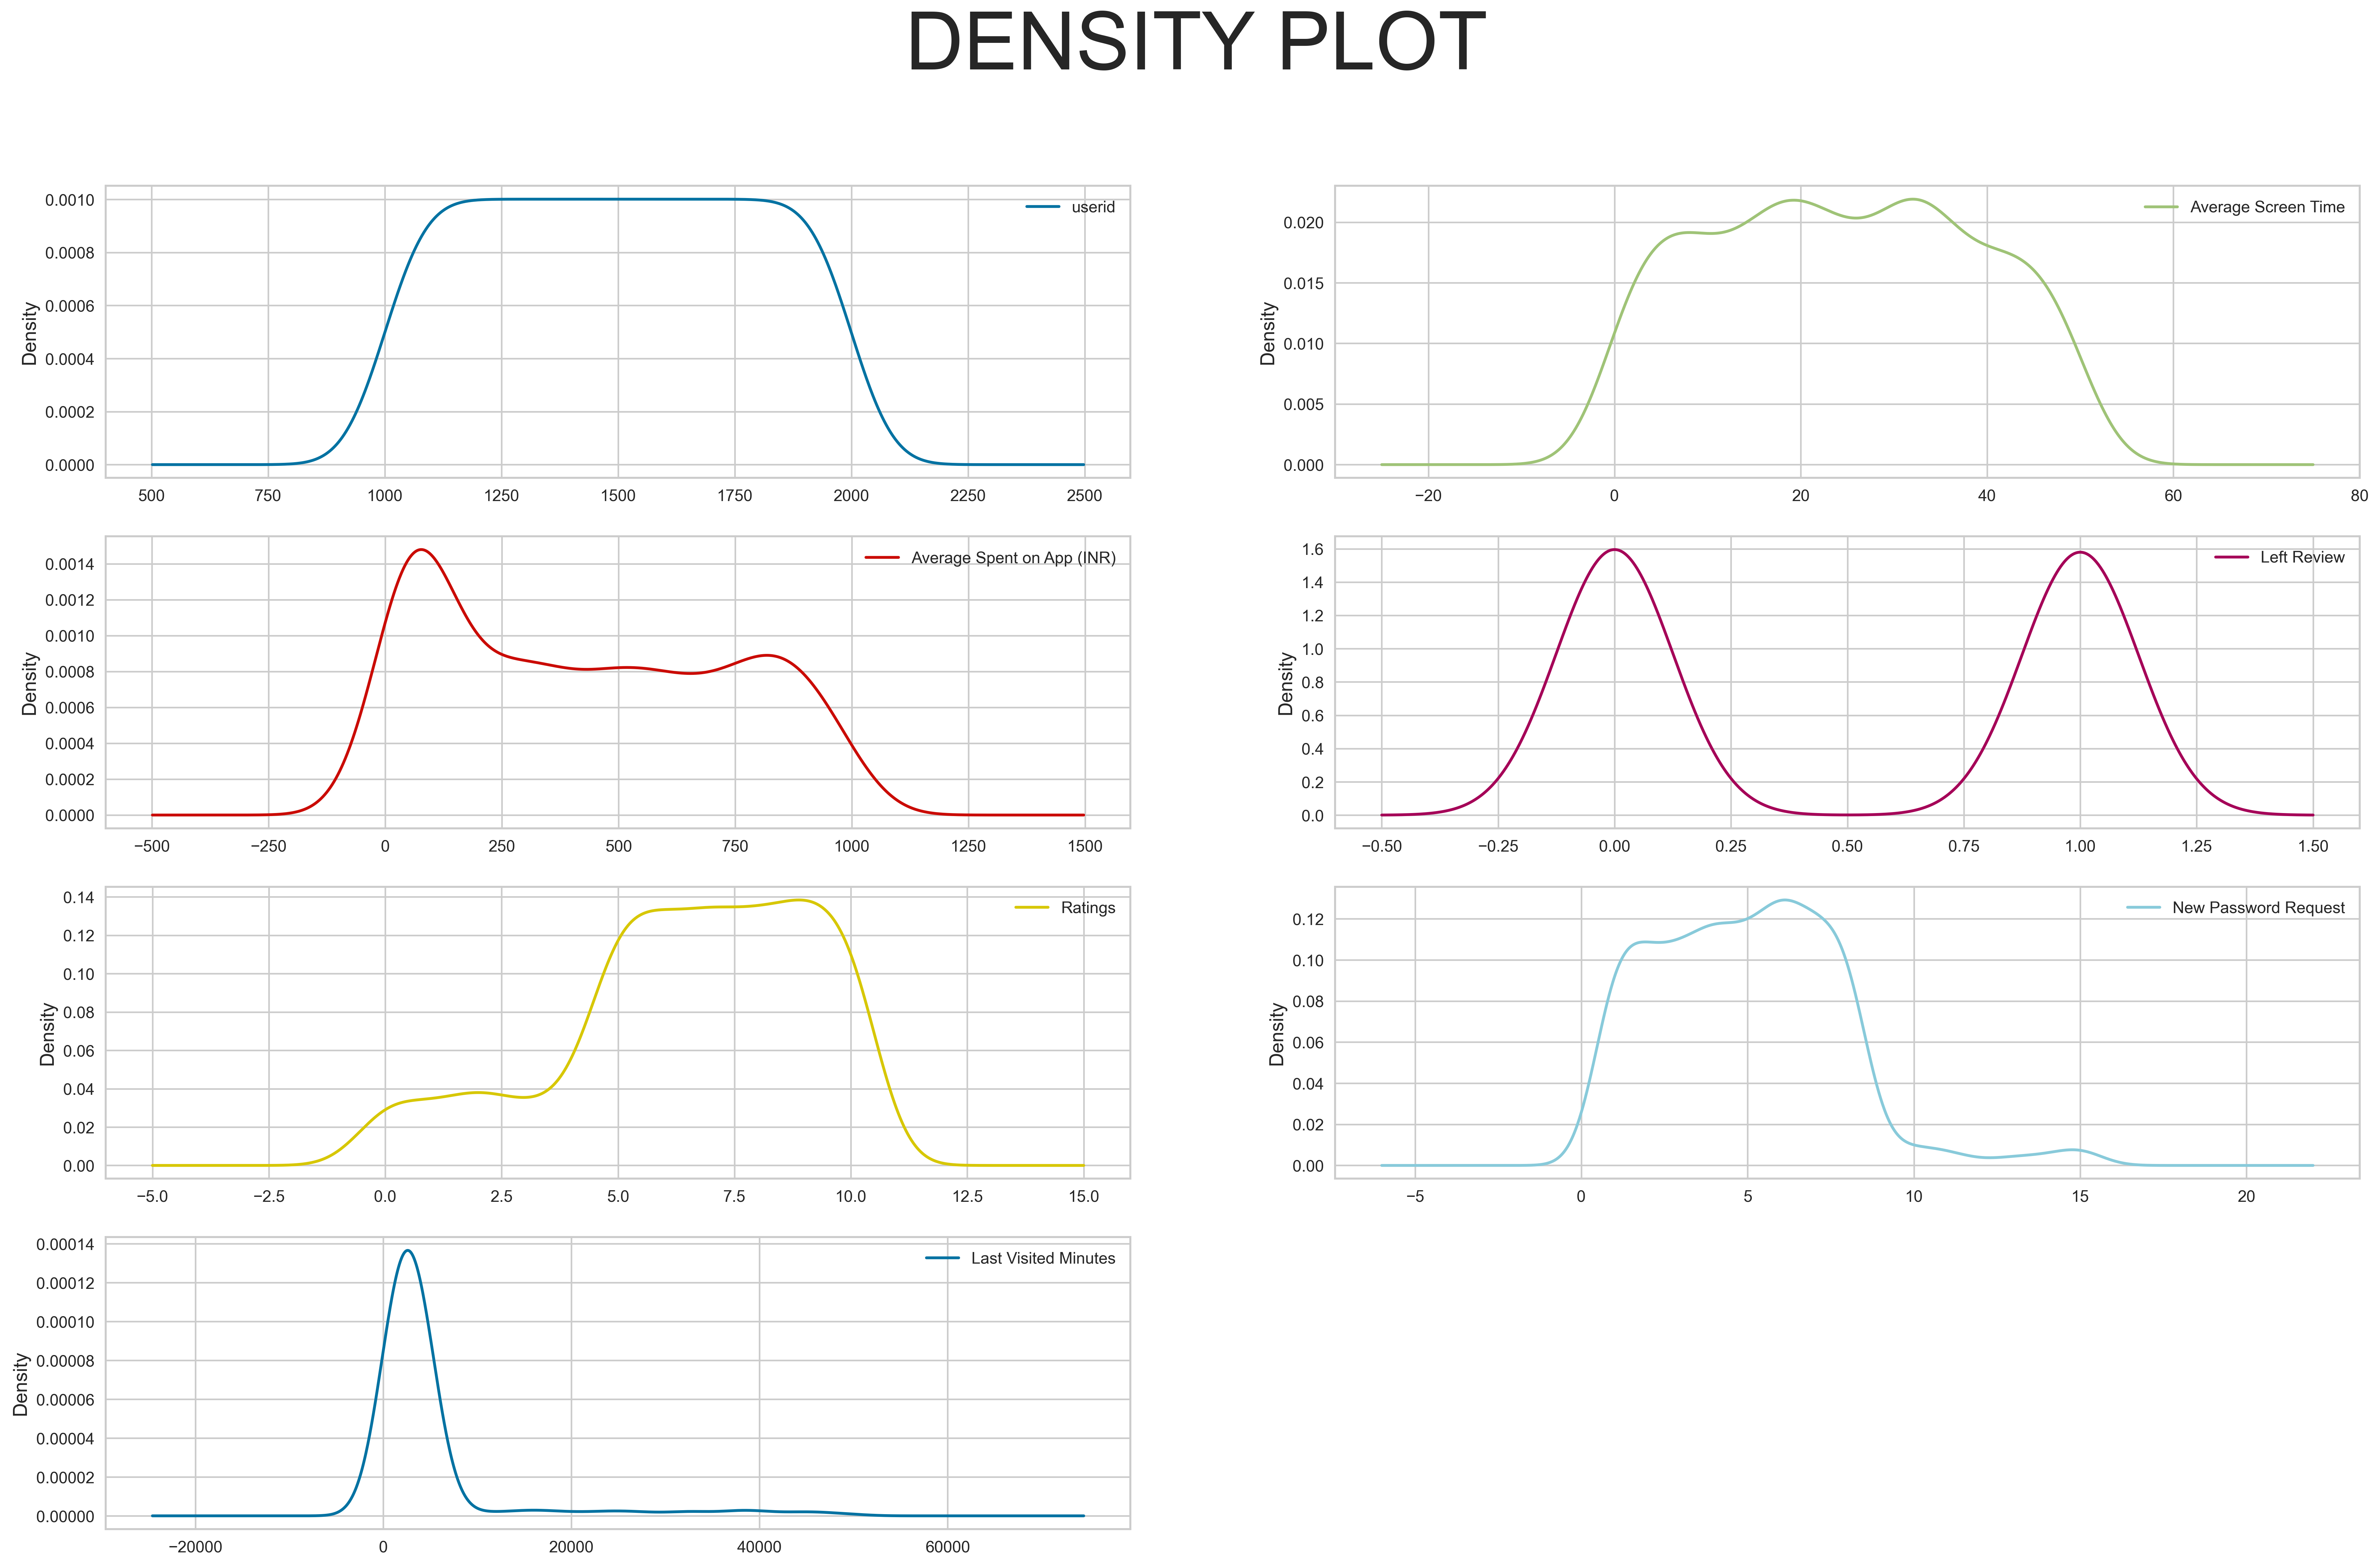

In [10]:
# densitiy plot to visualize distribution of numerical data

df.plot(kind='density', subplots=True, layout=(4,2), sharex=False, figsize=(25, 15));
plt.suptitle('DENSITY PLOT', fontsize = 50)
plt.show()

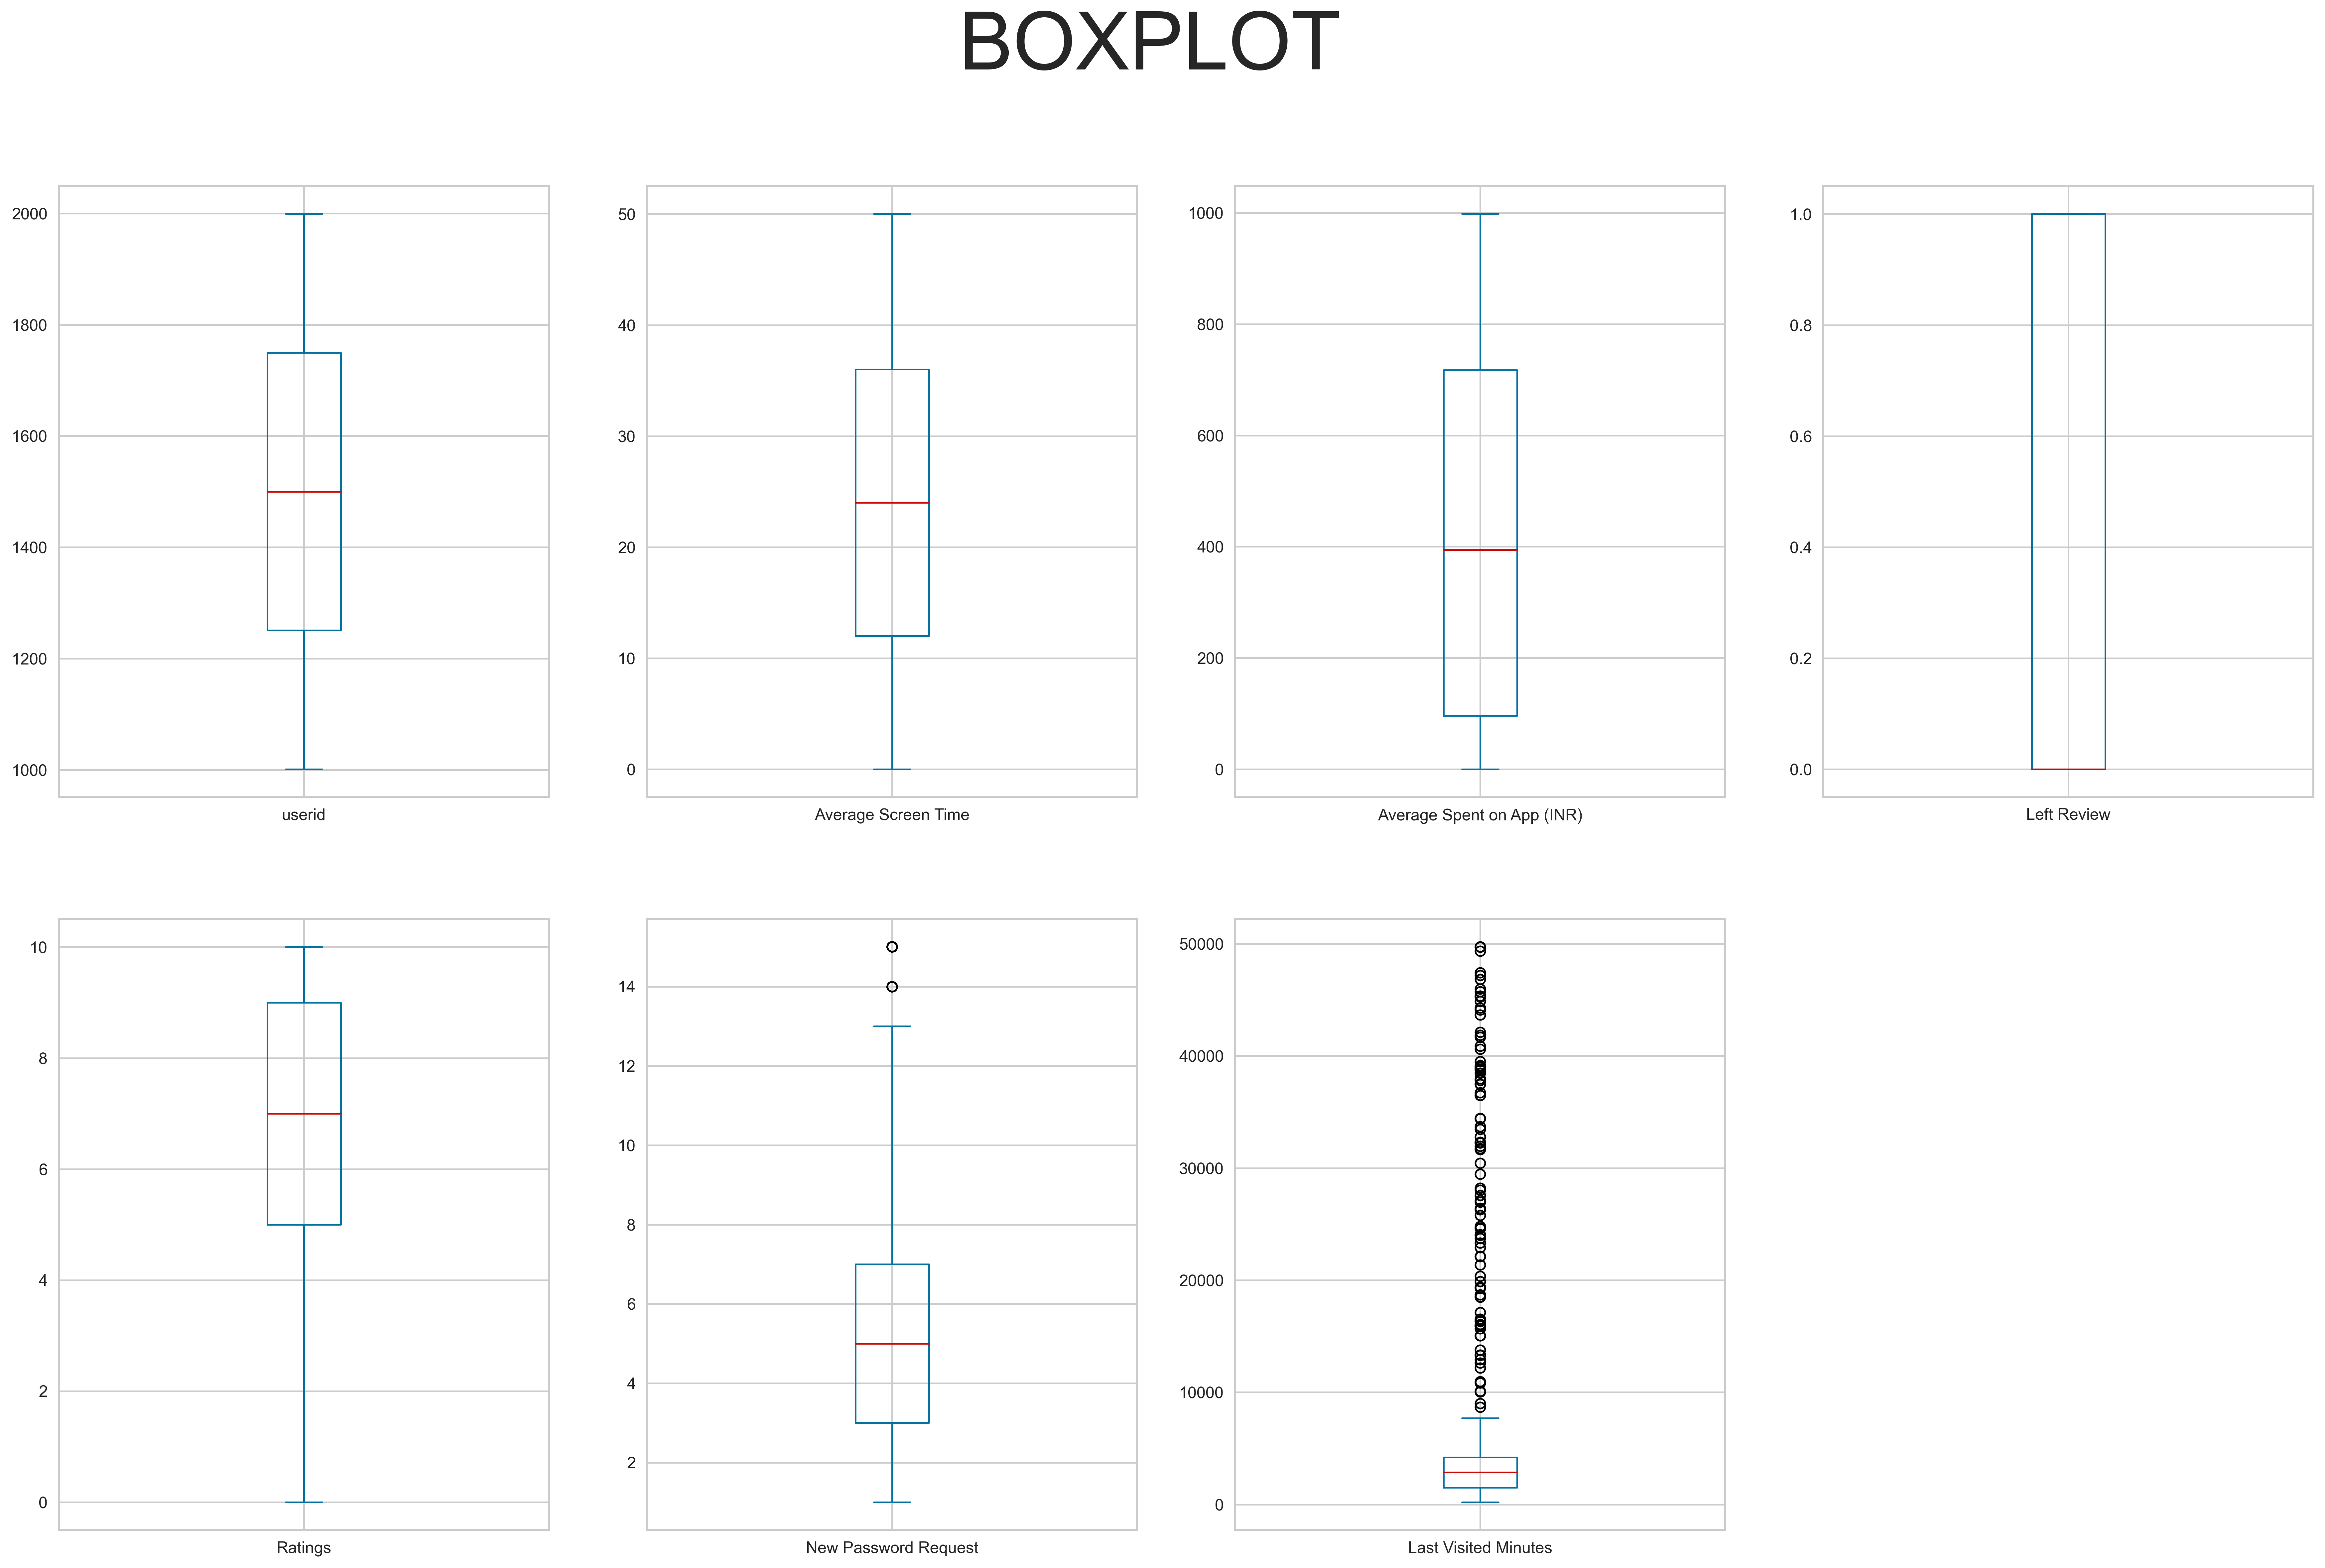

In [11]:
# boxplot of visualize presence of outlier for numerical data

df.plot(kind='box', subplots=True, layout=(2,4), sharex=False, figsize=(25, 15));
plt.suptitle('BOXPLOT', fontsize = 50)
plt.show()

**We choose to keep the outliers to assess the influence of extreme user cases on our segmentation model. This allows us to evaluate how effectively the model can perform clustering in the presence of outliers**

In [12]:
df.head()

userid  Average Screen Time  Average Spent on App (INR)  Left Review  \
0    1001                 17.0                       634.0            1   
1    1002                  0.0                        54.0            0   
2    1003                 37.0                       207.0            0   
3    1004                 32.0                       445.0            1   
4    1005                 45.0                       427.0            1   

   Ratings  New Password Request  Last Visited Minutes       Status  
0        9                     7                  2990    Installed  
1        4                     8                 24008  Uninstalled  
2        8                     5                   971    Installed  
3        6                     2                   799    Installed  
4        5                     6                  3668    Installed

### Behavior Analysis
- Examining the behvaior of users related to their usage, screentime, spending capacity & rating given wrt to Status

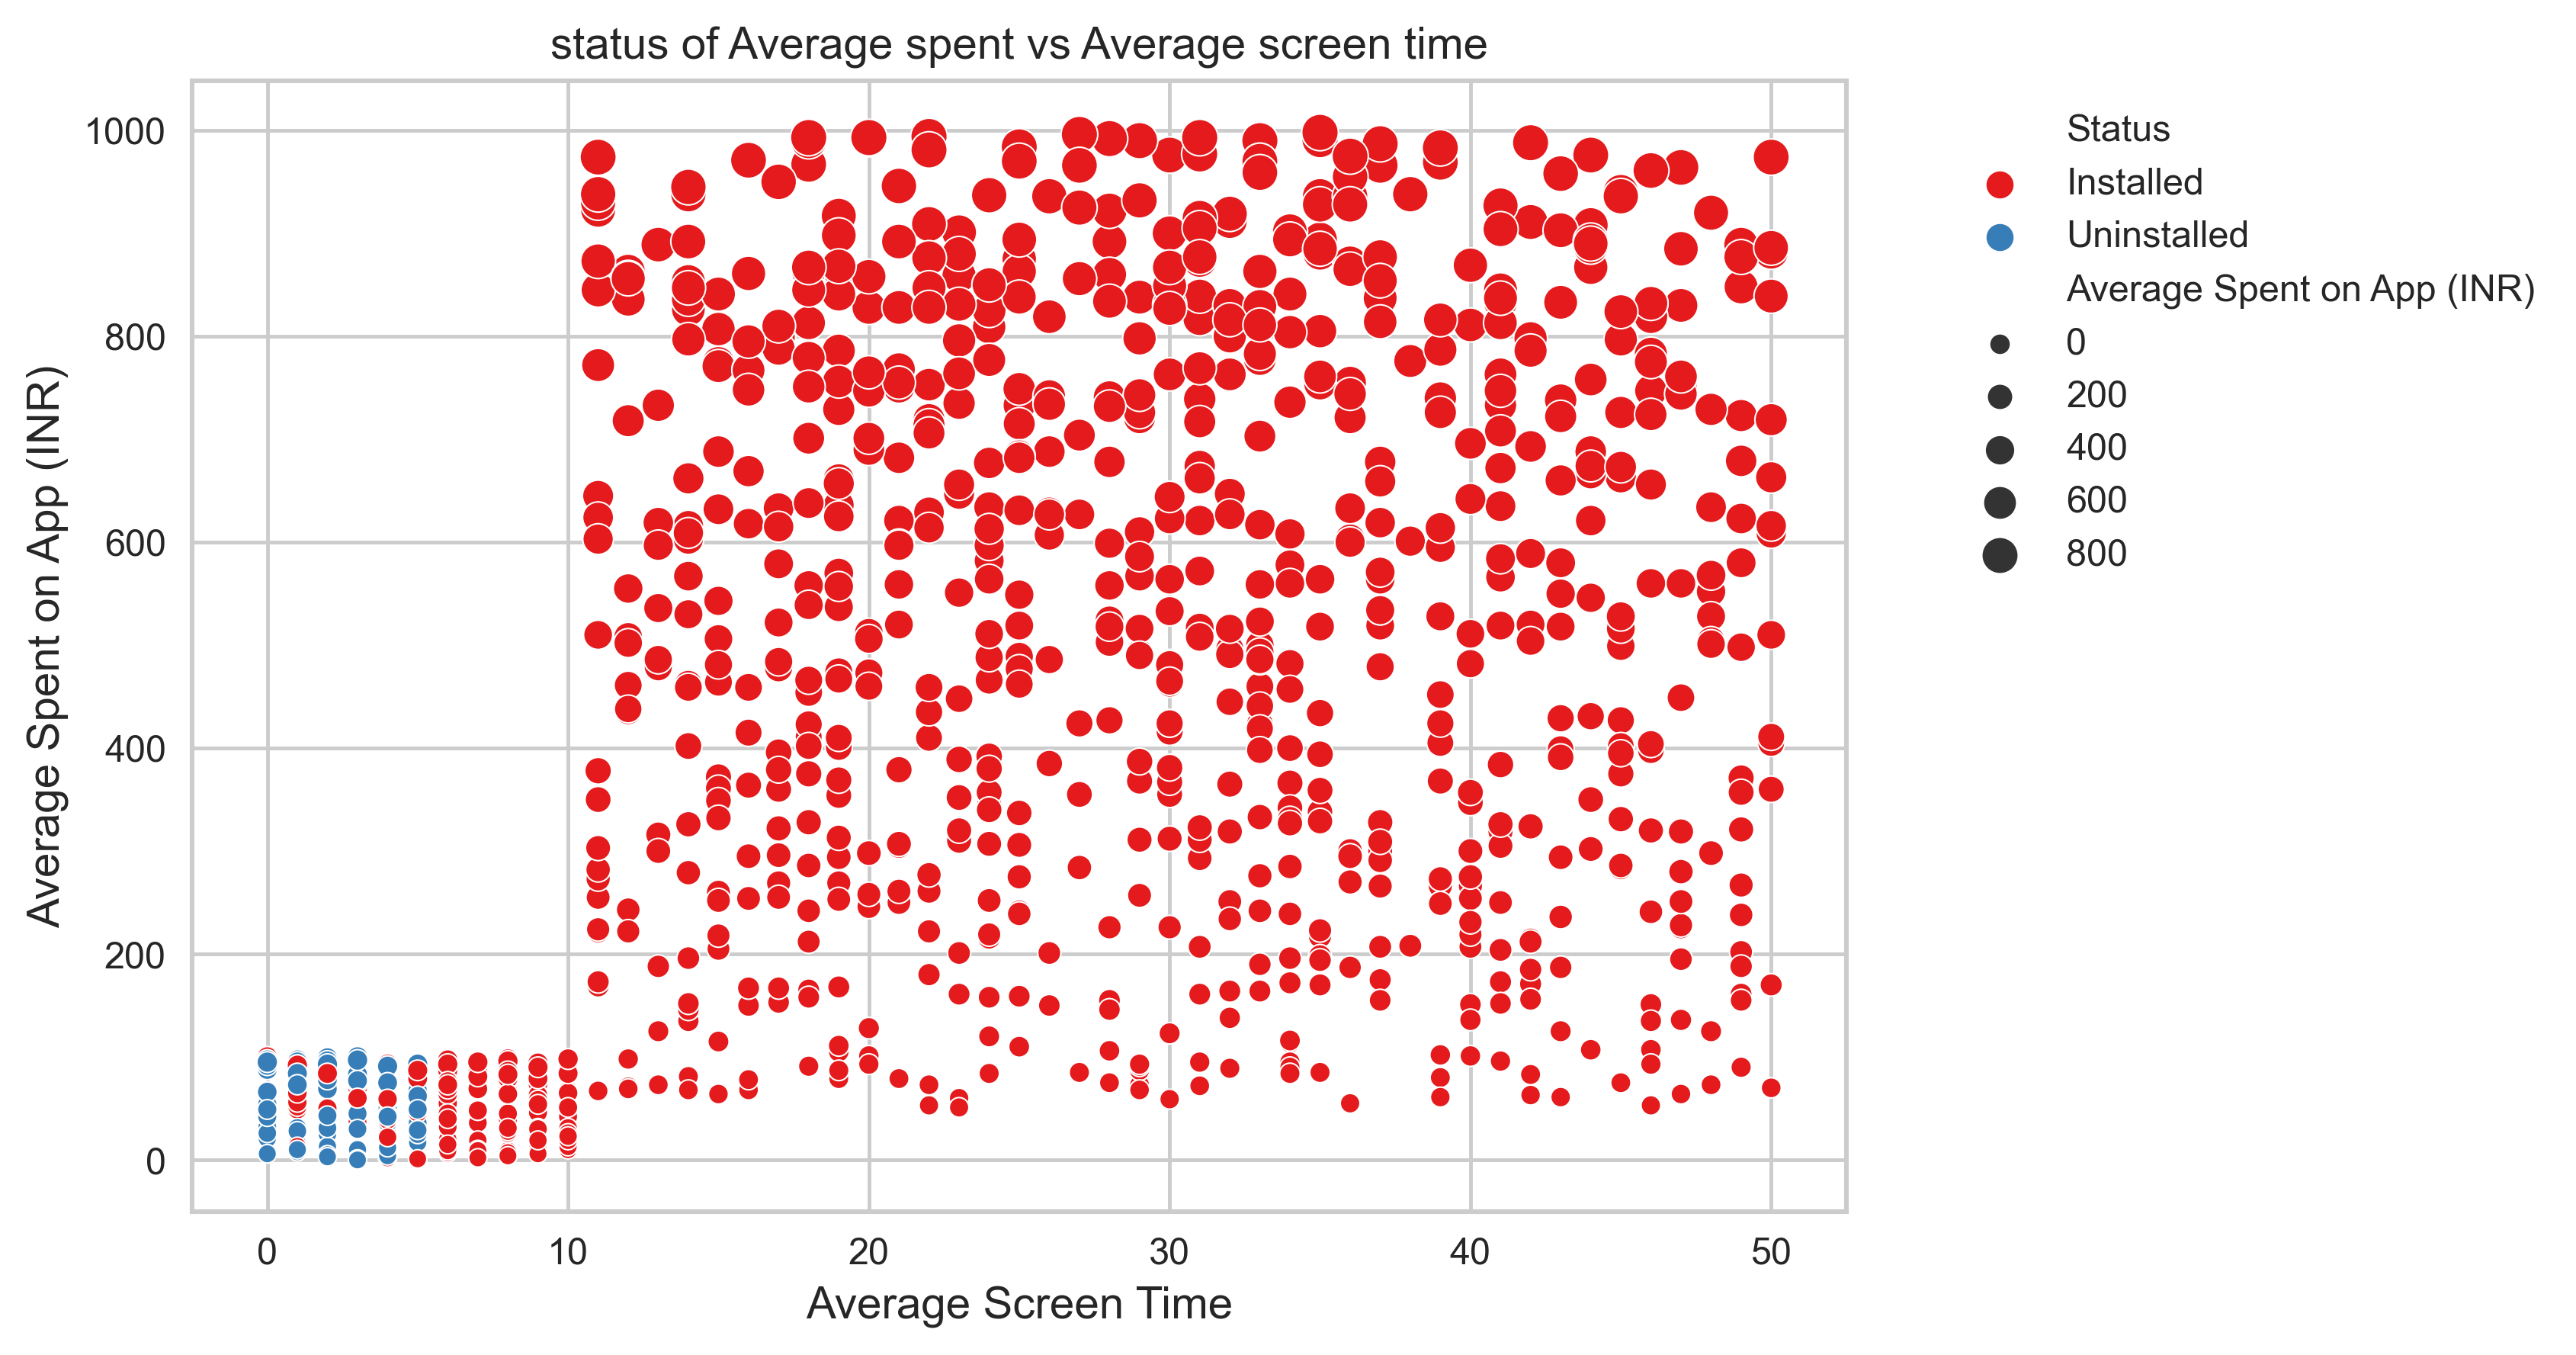

In [13]:
ax = sns.scatterplot(data = df, x = 'Average Screen Time', y = 'Average Spent on App (INR)',
                hue = 'Status', palette='Set1',size='Average Spent on App (INR)')
ax.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.5, fontsize='small')
plt.title('status of Average spent vs Average screen time')
plt.show()

**it can be observed that the the user user with less average screen time are more lilkely to have that app uninstalled from their device also the average screen time is less than 5 minutes of those users who have uninstalled the app**

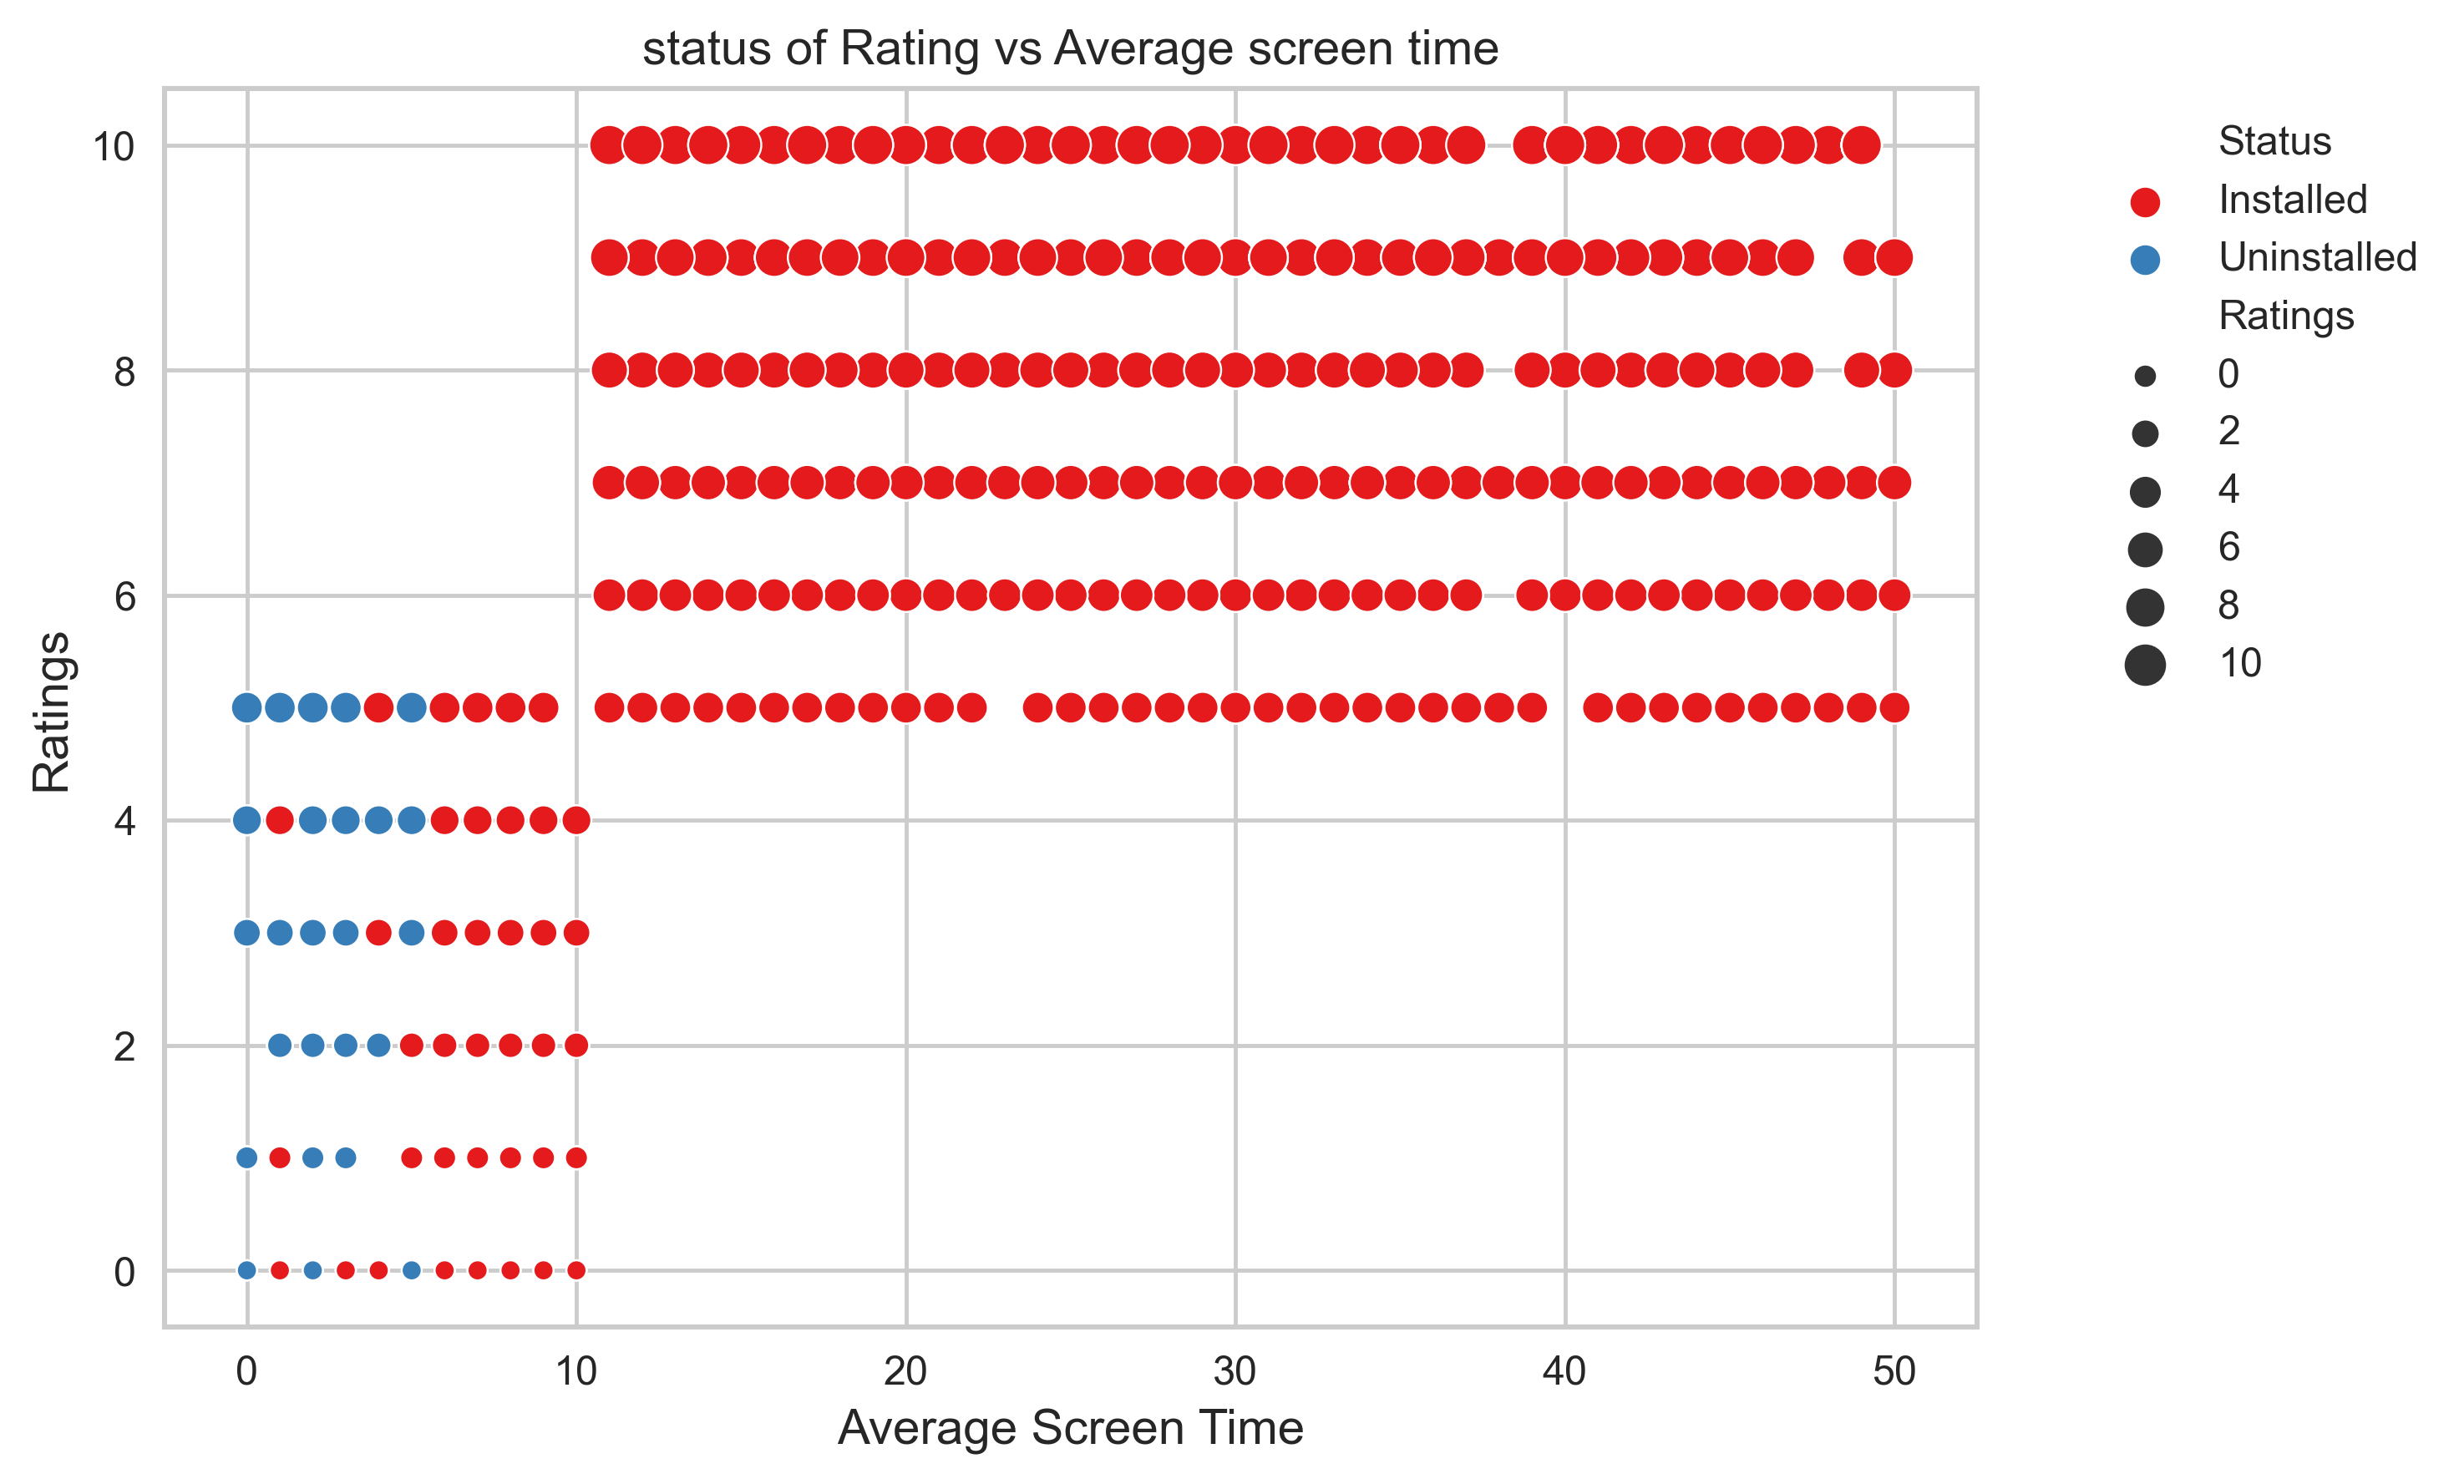

In [14]:
ax = sns.scatterplot(data = df, x = 'Average Screen Time', y = 'Ratings', hue = 'Status', palette='Set1', size = 'Ratings')
ax.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.5, fontsize='small')
plt.title('status of Rating vs Average screen time')
plt.show()

**Individuals who install the app and exhibit elevated screen time are inclined to provide an above-average rating. Conversely, users with lower screen time are more prone to assign a below-average rating and are also more likely to uninstall the app**

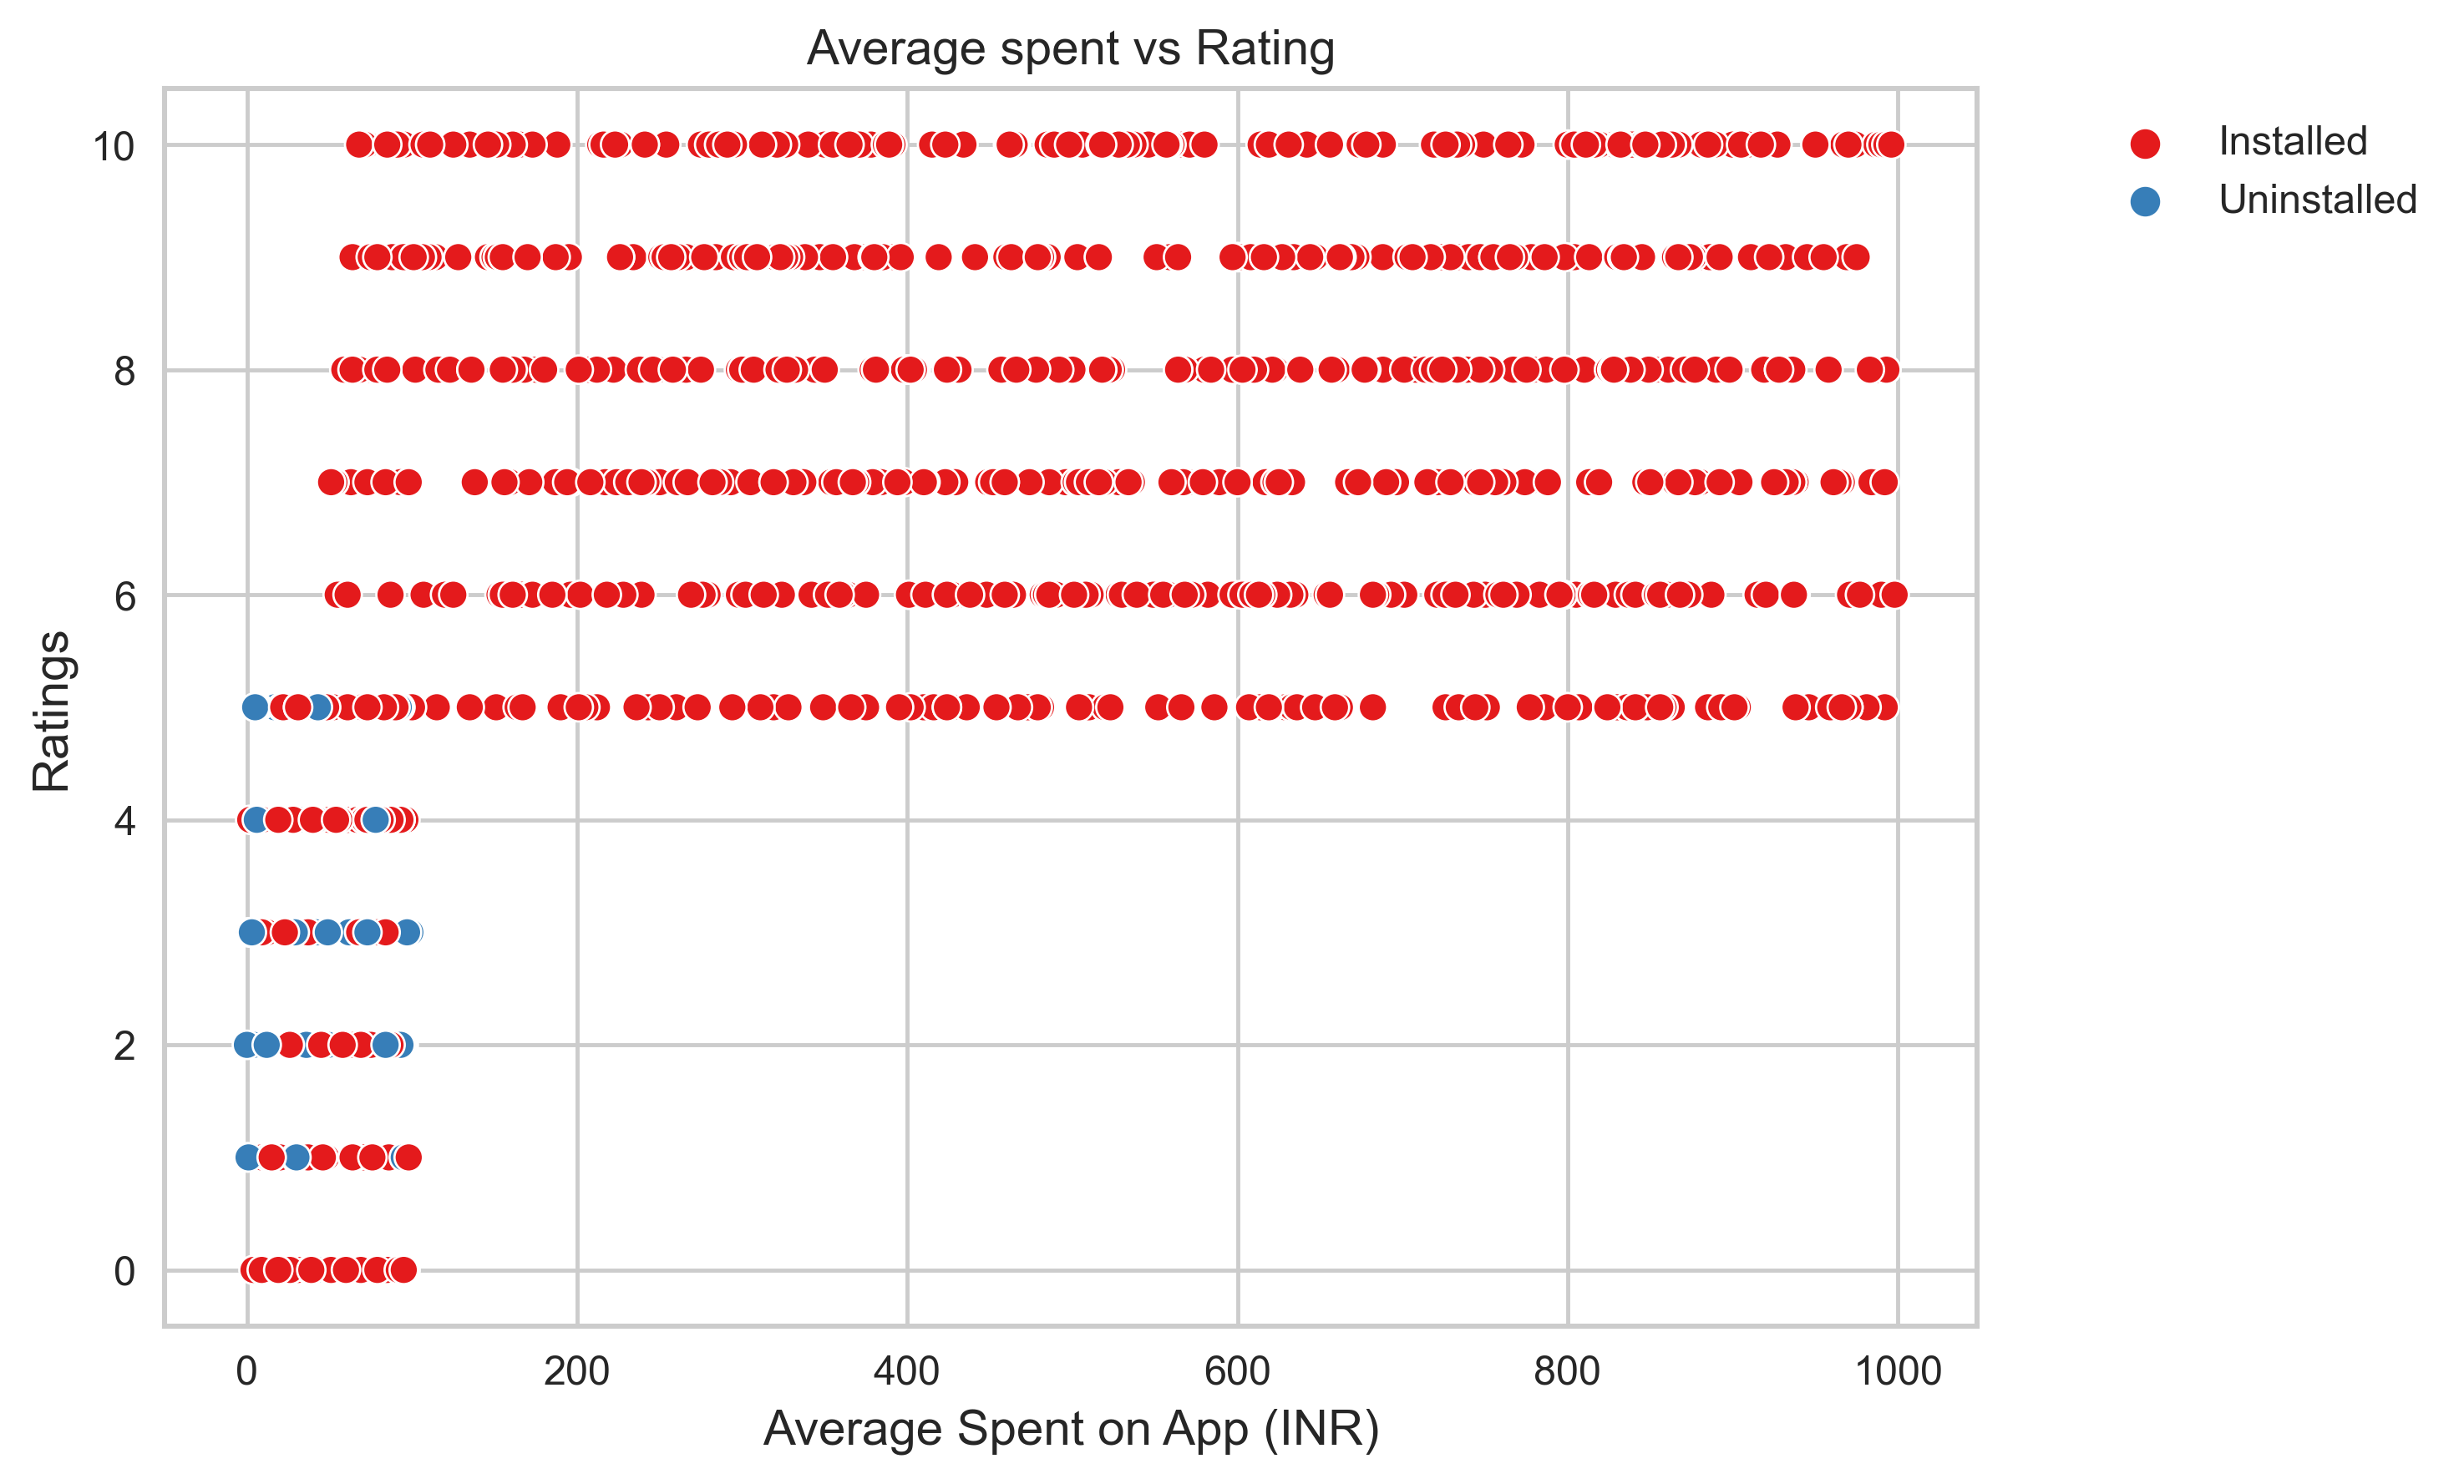

In [15]:
ax = sns.scatterplot(data = df, x = 'Average Spent on App (INR)', y = 'Ratings', hue = 'Status', palette='Set1')
plt.title('Average spent vs Rating')
ax.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.5, fontsize='small')
plt.show()

**It's noticeable that those who spent around 100 rupees but ended up uninstalling the app usually gave a maximum rating of 5 out of 10. In contrast, users with greater spending capacity, who not only installed the app but also made purchases, tend to give higher ratings.**

### user status comparision
- Comparing the characteristics of users who have uninstalled the app with those who are still installed

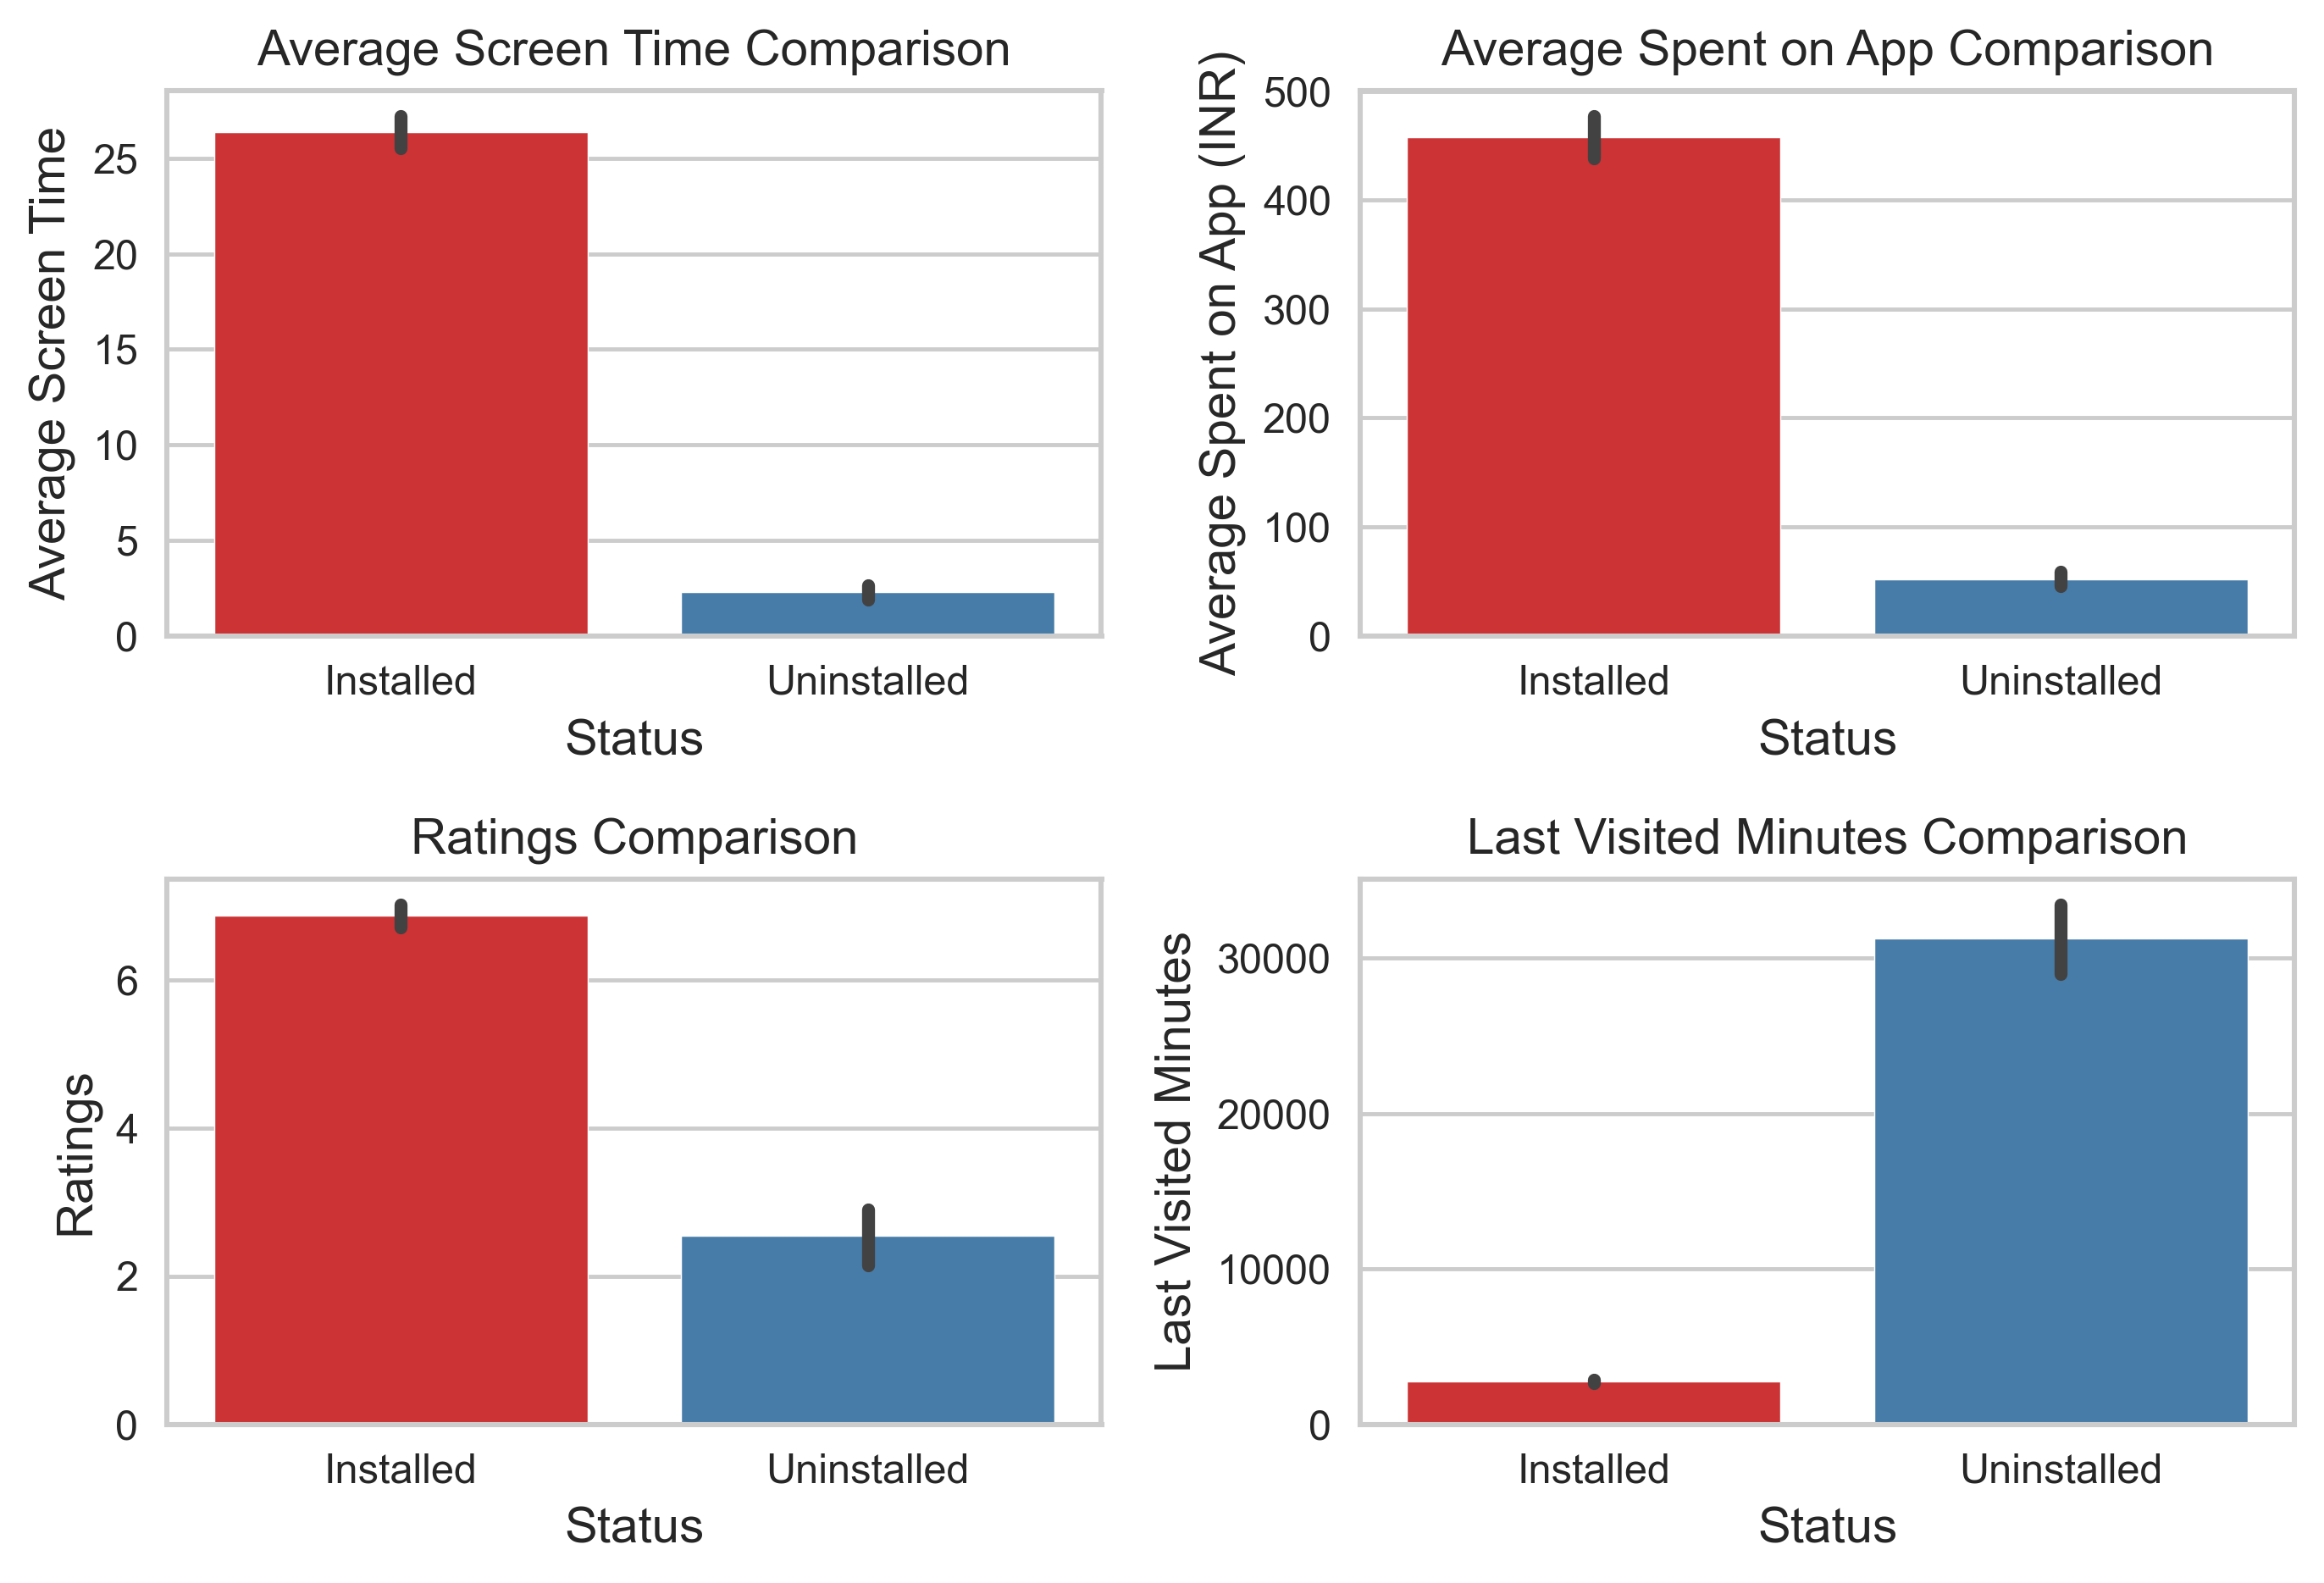

In [16]:
plt.subplot(2, 2, 1)
sns.barplot(x='Status', y='Average Screen Time', data=df,palette='Set1')
plt.title('Average Screen Time Comparison')

# Box plot for Average Spent on App
plt.subplot(2, 2, 2)
sns.barplot(x='Status', y='Average Spent on App (INR)', data=df,palette='Set1')
plt.title('Average Spent on App Comparison')

# Box plot for Ratings
plt.subplot(2, 2, 3)
sns.barplot(x='Status', y='Ratings', data=df,palette='Set1')
plt.title('Ratings Comparison')

# Box plot for Last Visited Minutes
plt.subplot(2, 2, 4)
sns.barplot(x='Status', y='Last Visited Minutes', data=df,palette='Set1')
plt.title('Last Visited Minutes Comparison')
plt.tight_layout()

- **Users typically exhibit higher screen time when they have the app installed compared to those who don't have it on their device**
- **The average spending is notably elevated among users who have the app installed on their devices**
- **ratings provided by users with the app installed are significantly higher (approximately twice as much) compared to users without the app installed**
- **The time of the last visit is markedly longer among users who don't have the app installed on their devices**

<Axes: >

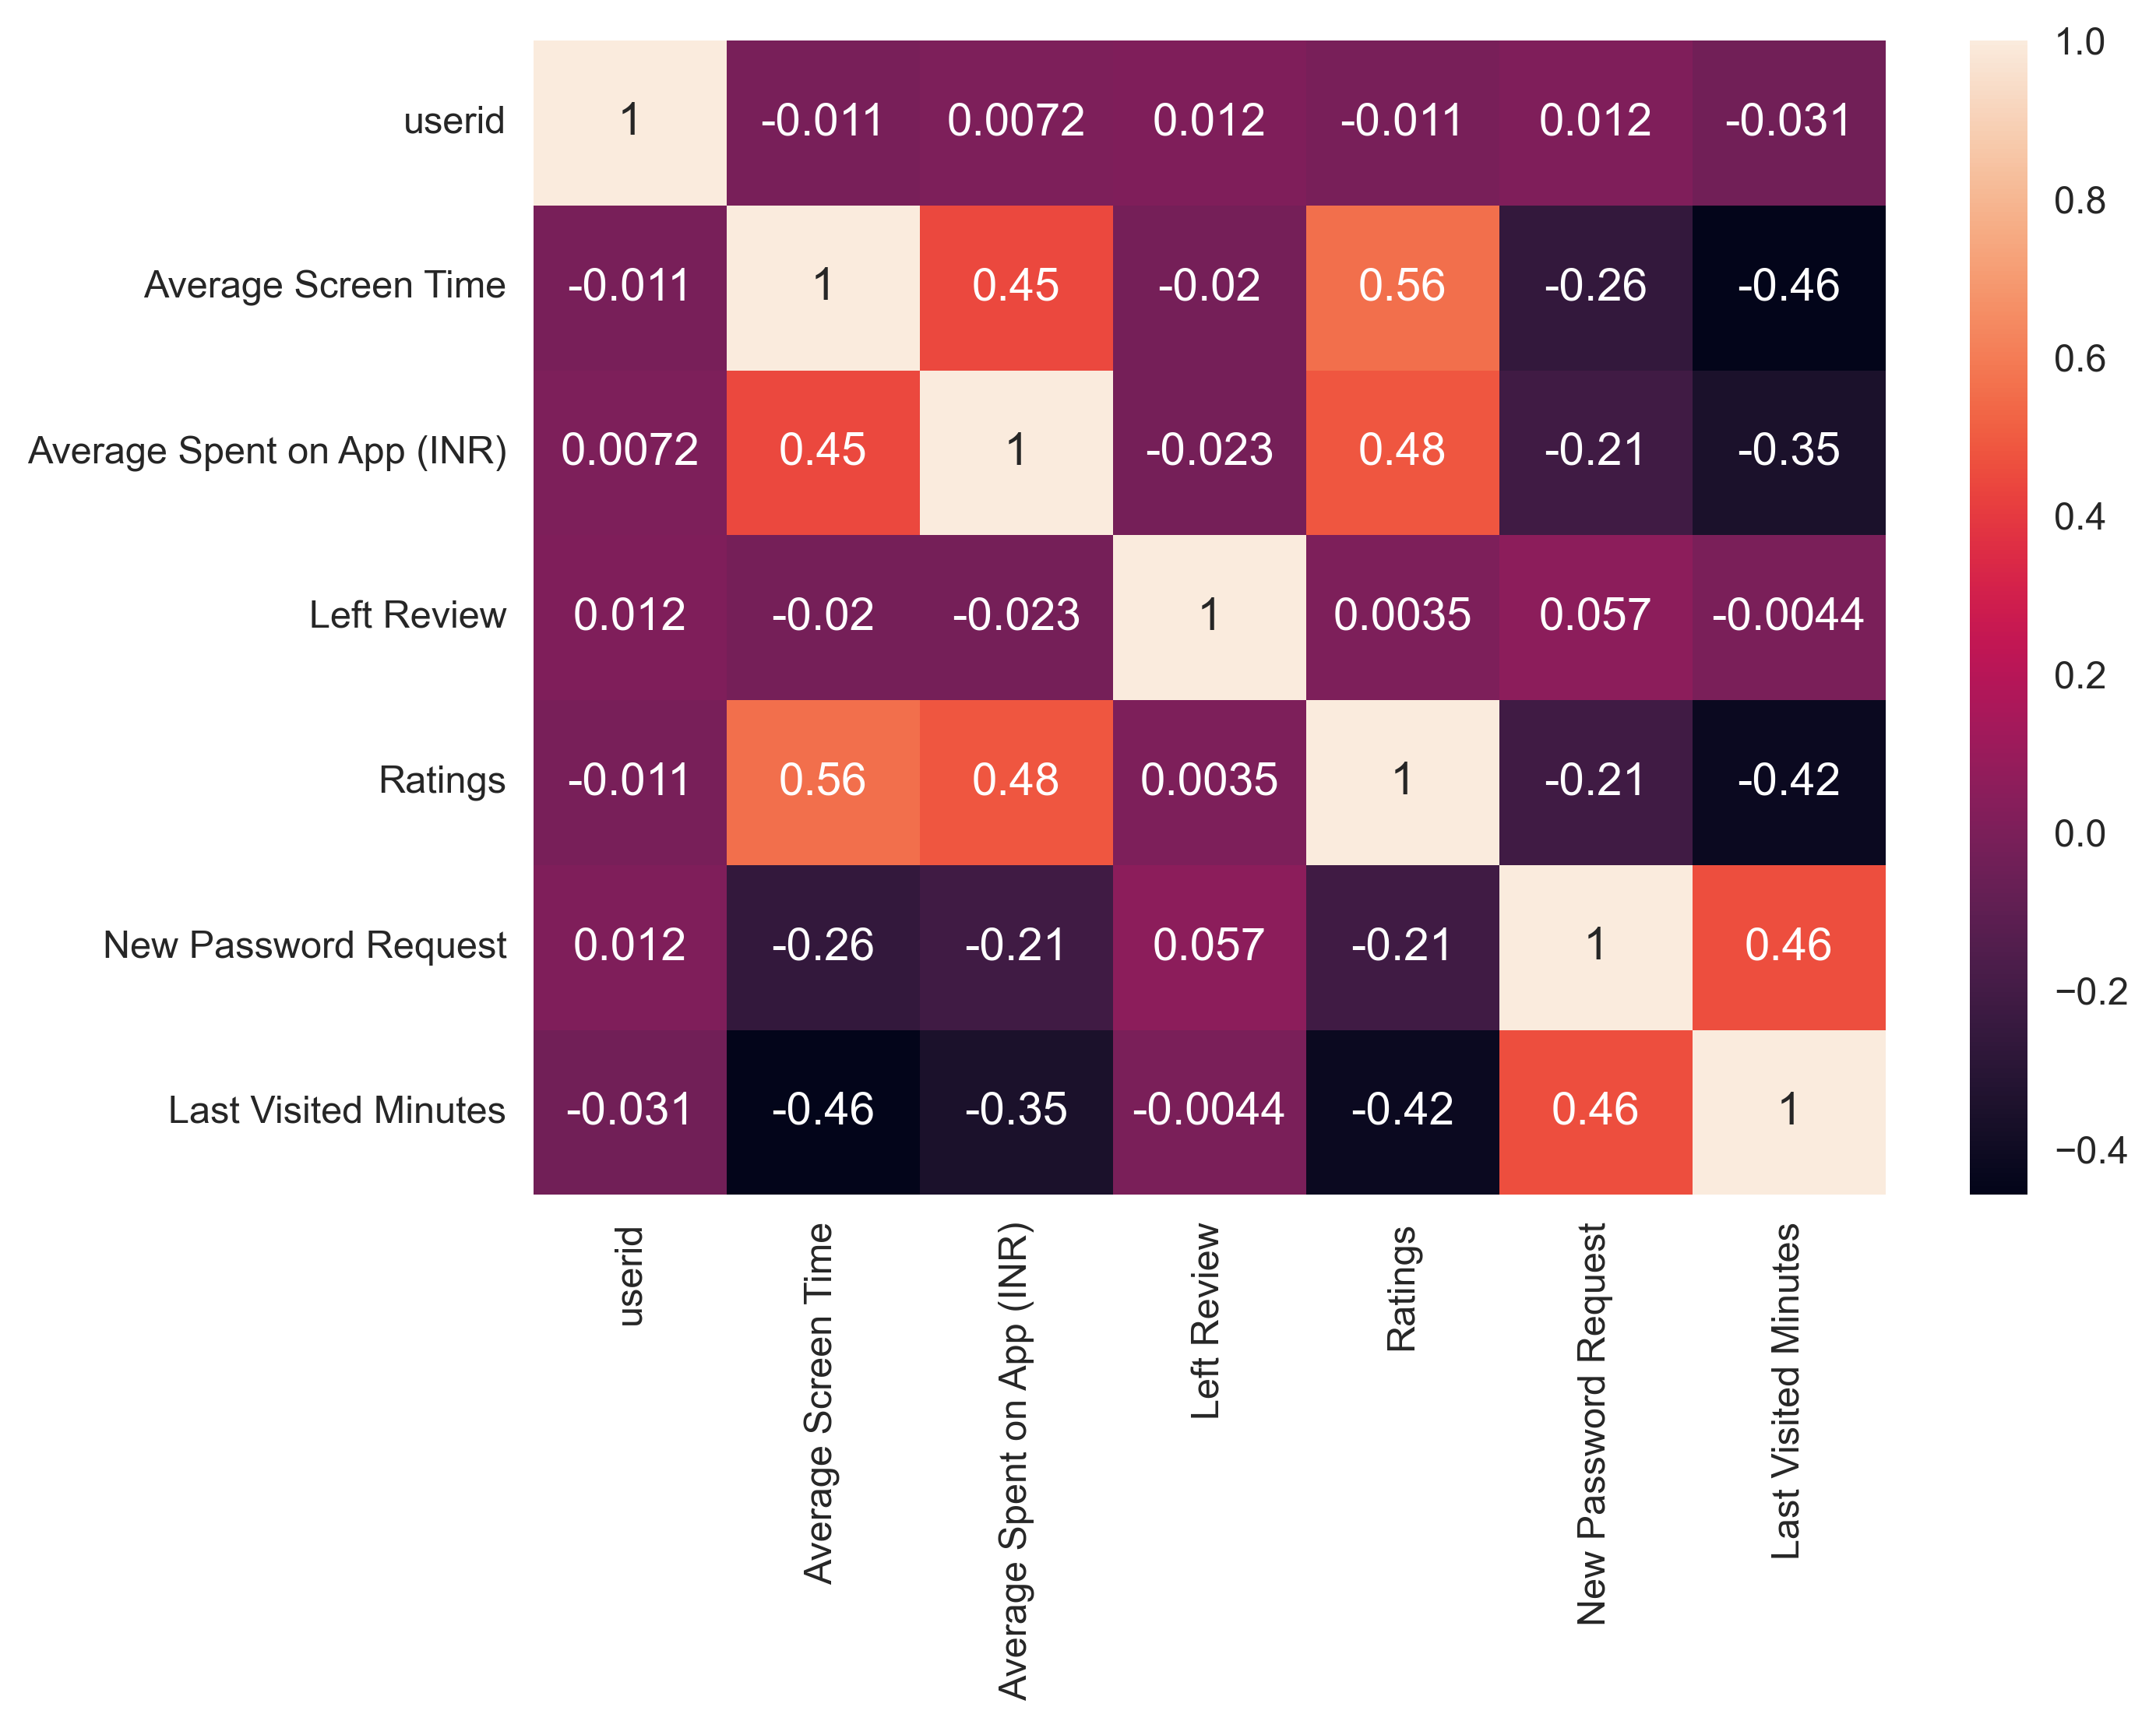

In [17]:
sns.heatmap(df.corr(), annot=True)

# User segmentation based on screen time & spending behviour

#### Featrure selection

In [18]:
# Select relevant features for clustering (average screen time and spending)
features = df[['Average Screen Time', 'Average Spent on App (INR)']]

#### feature scaling

In [19]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

### Checking for optimal value of k using elbow method

In [20]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

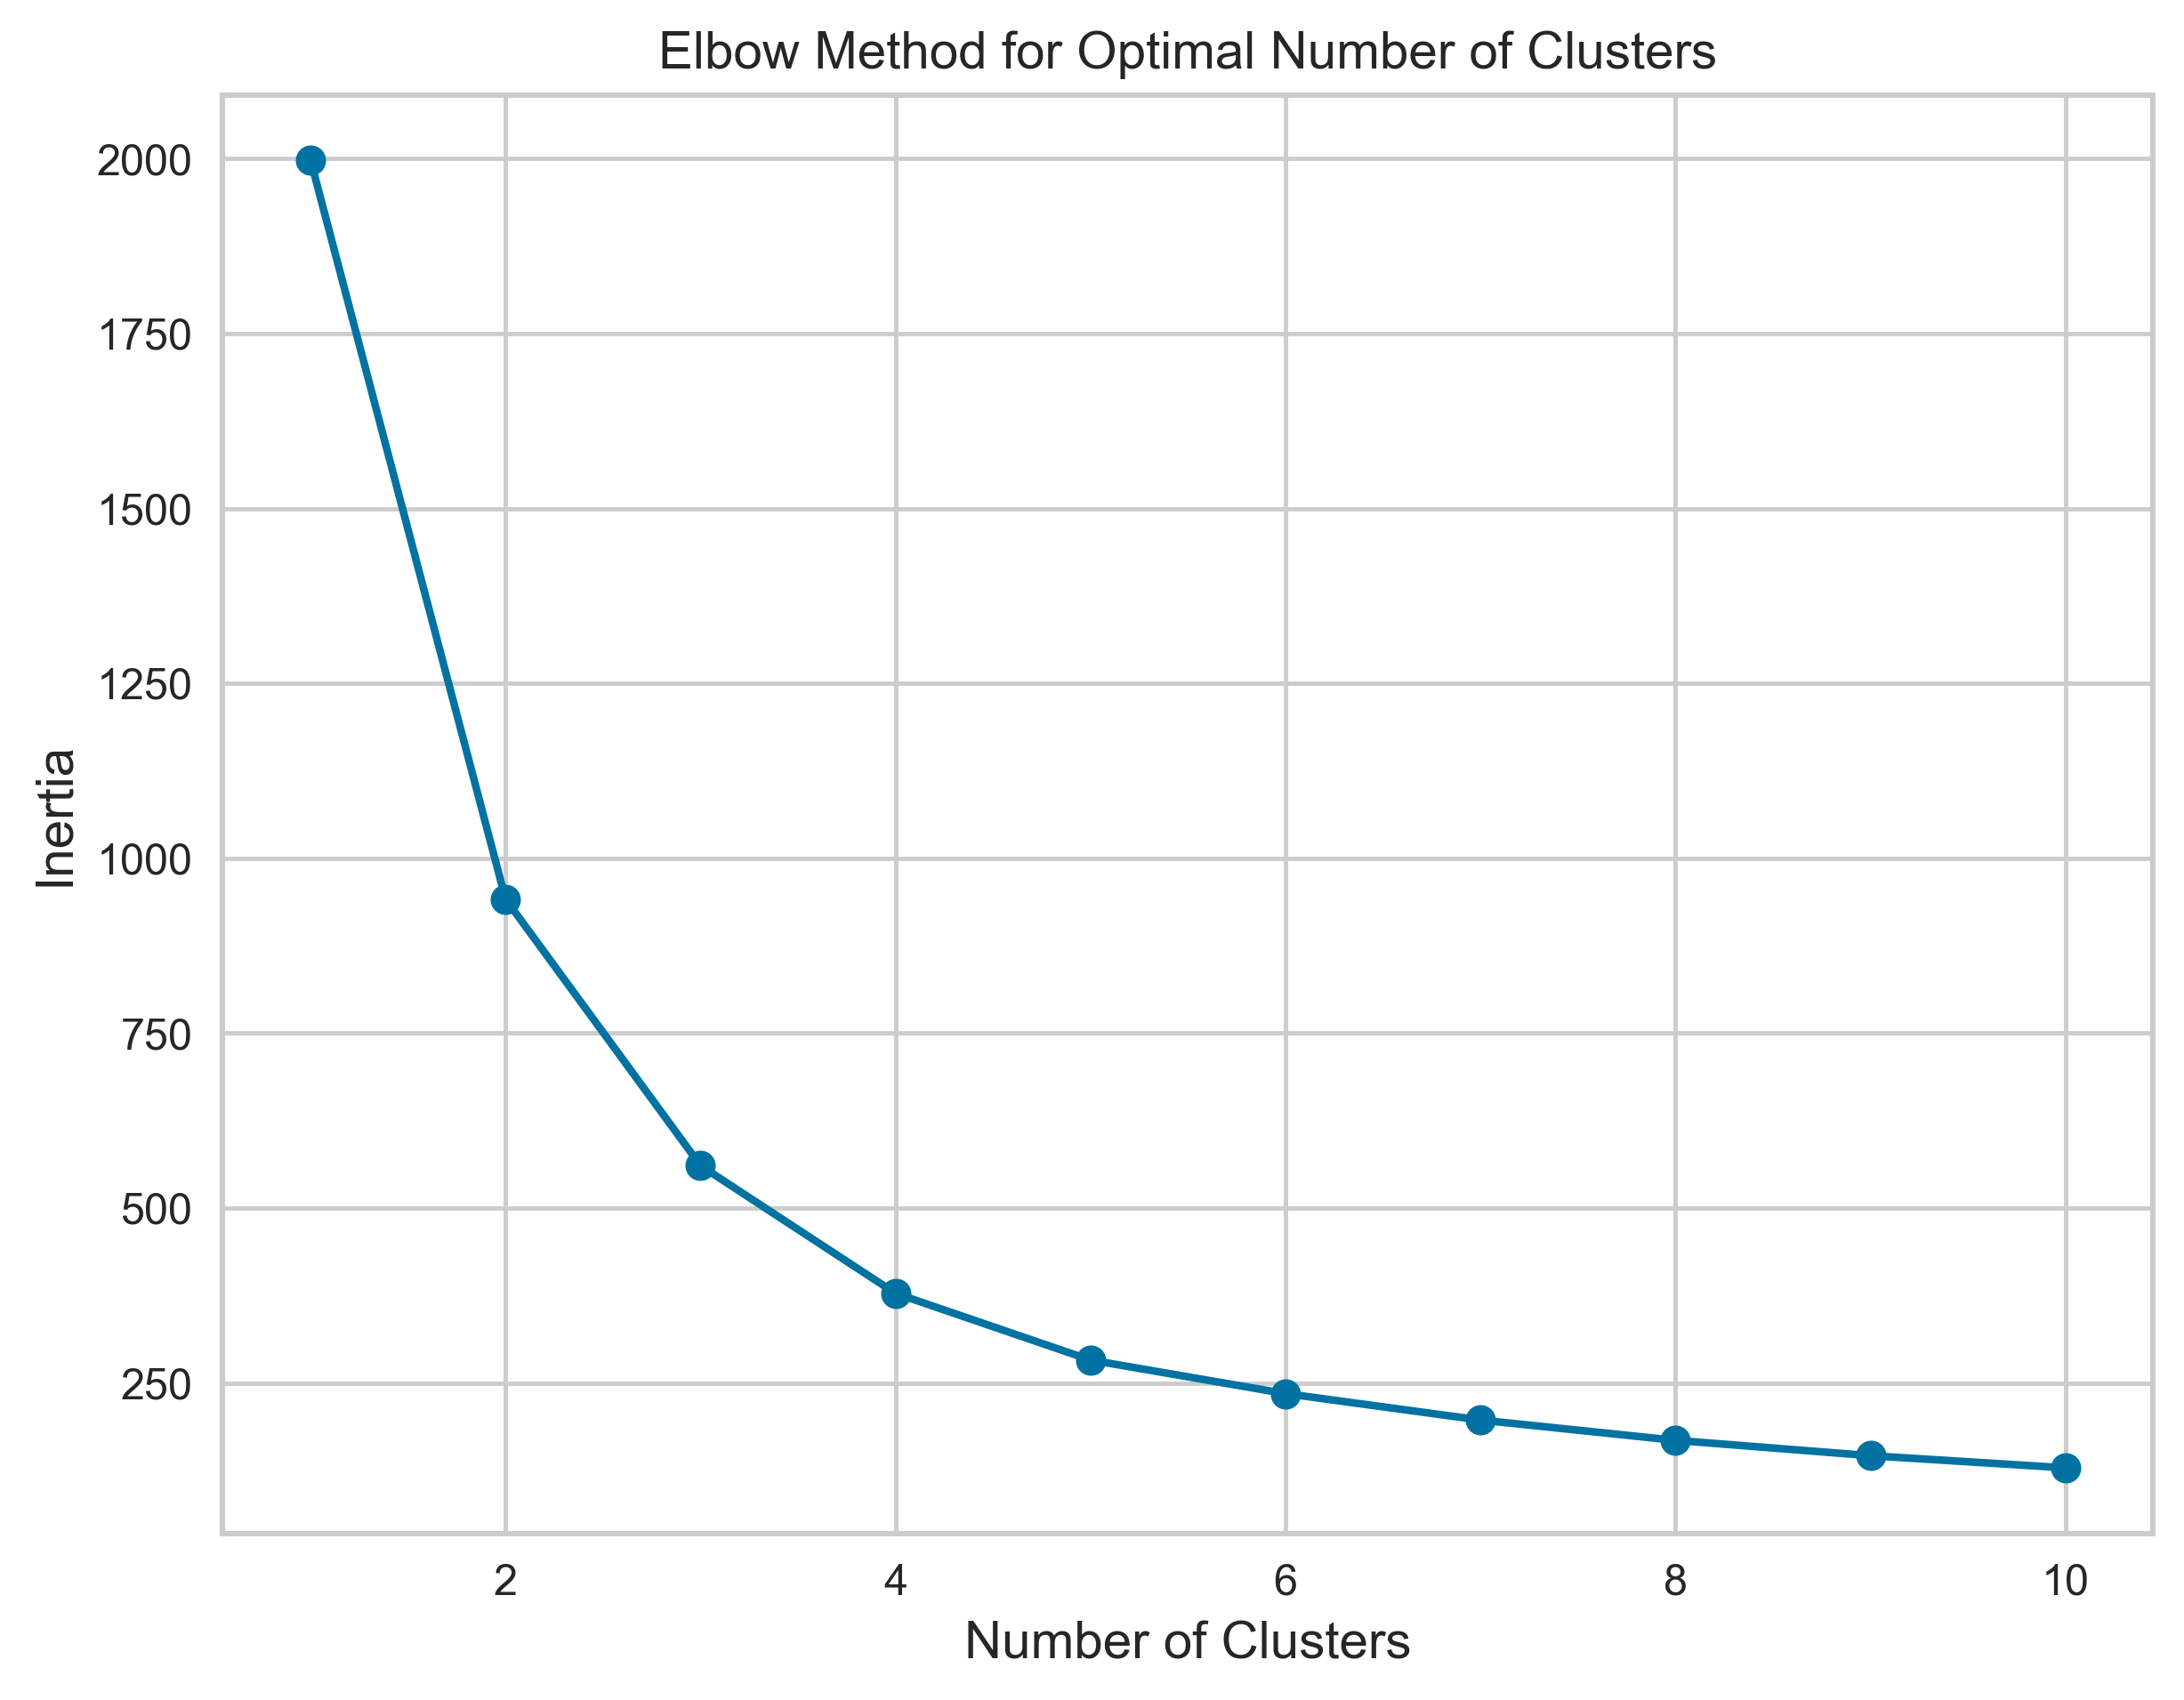

In [21]:
# Plot the Elbow Method to find the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


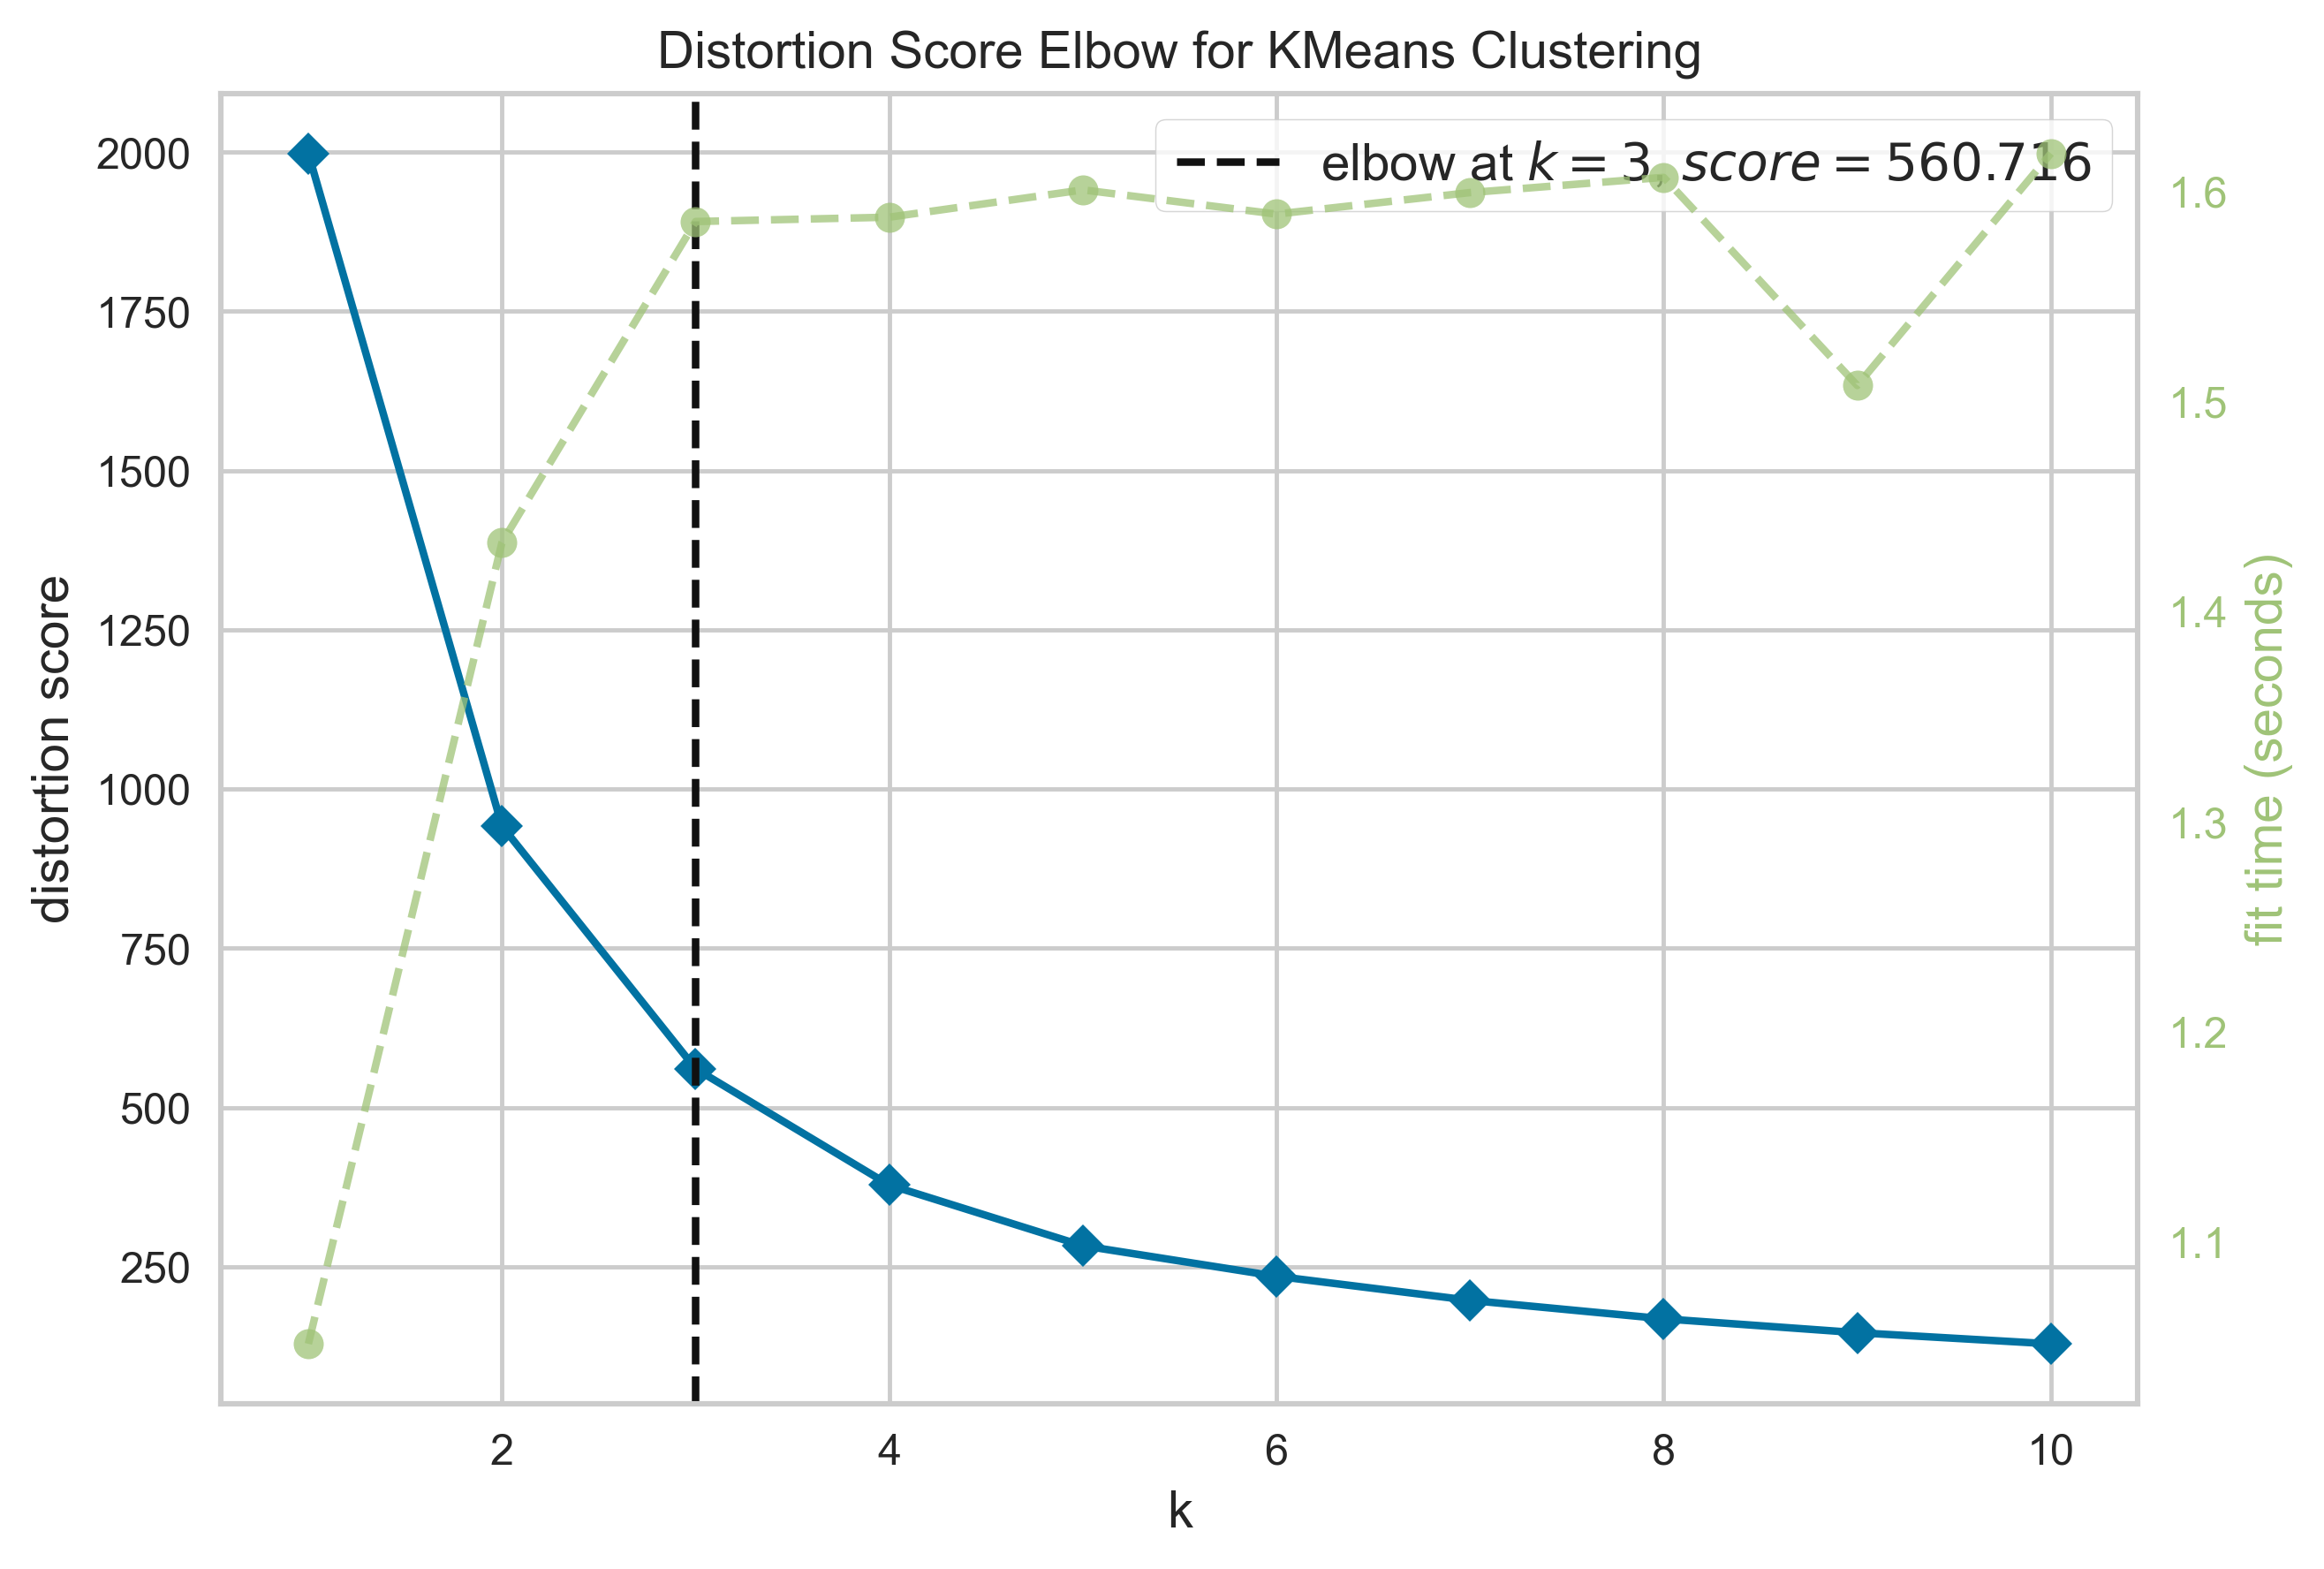

In [22]:
# alternative to elbow graph to find the optimal value of K
kmeans=KMeans()
visualizer=KElbowVisualizer(kmeans,k=(1,11))
visualizer.fit(features_scaled)
visualizer.poof()
plt.show()

### optimal vlaue of K = 3

In [23]:
# Based on the Elbow Method, choose the optimal number of clusters
optimal_clusters = 3

### Applying K-Means

In [24]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['Cluster_user_engangment'] = kmeans.fit_predict(features_scaled)

##### visualizing clusters

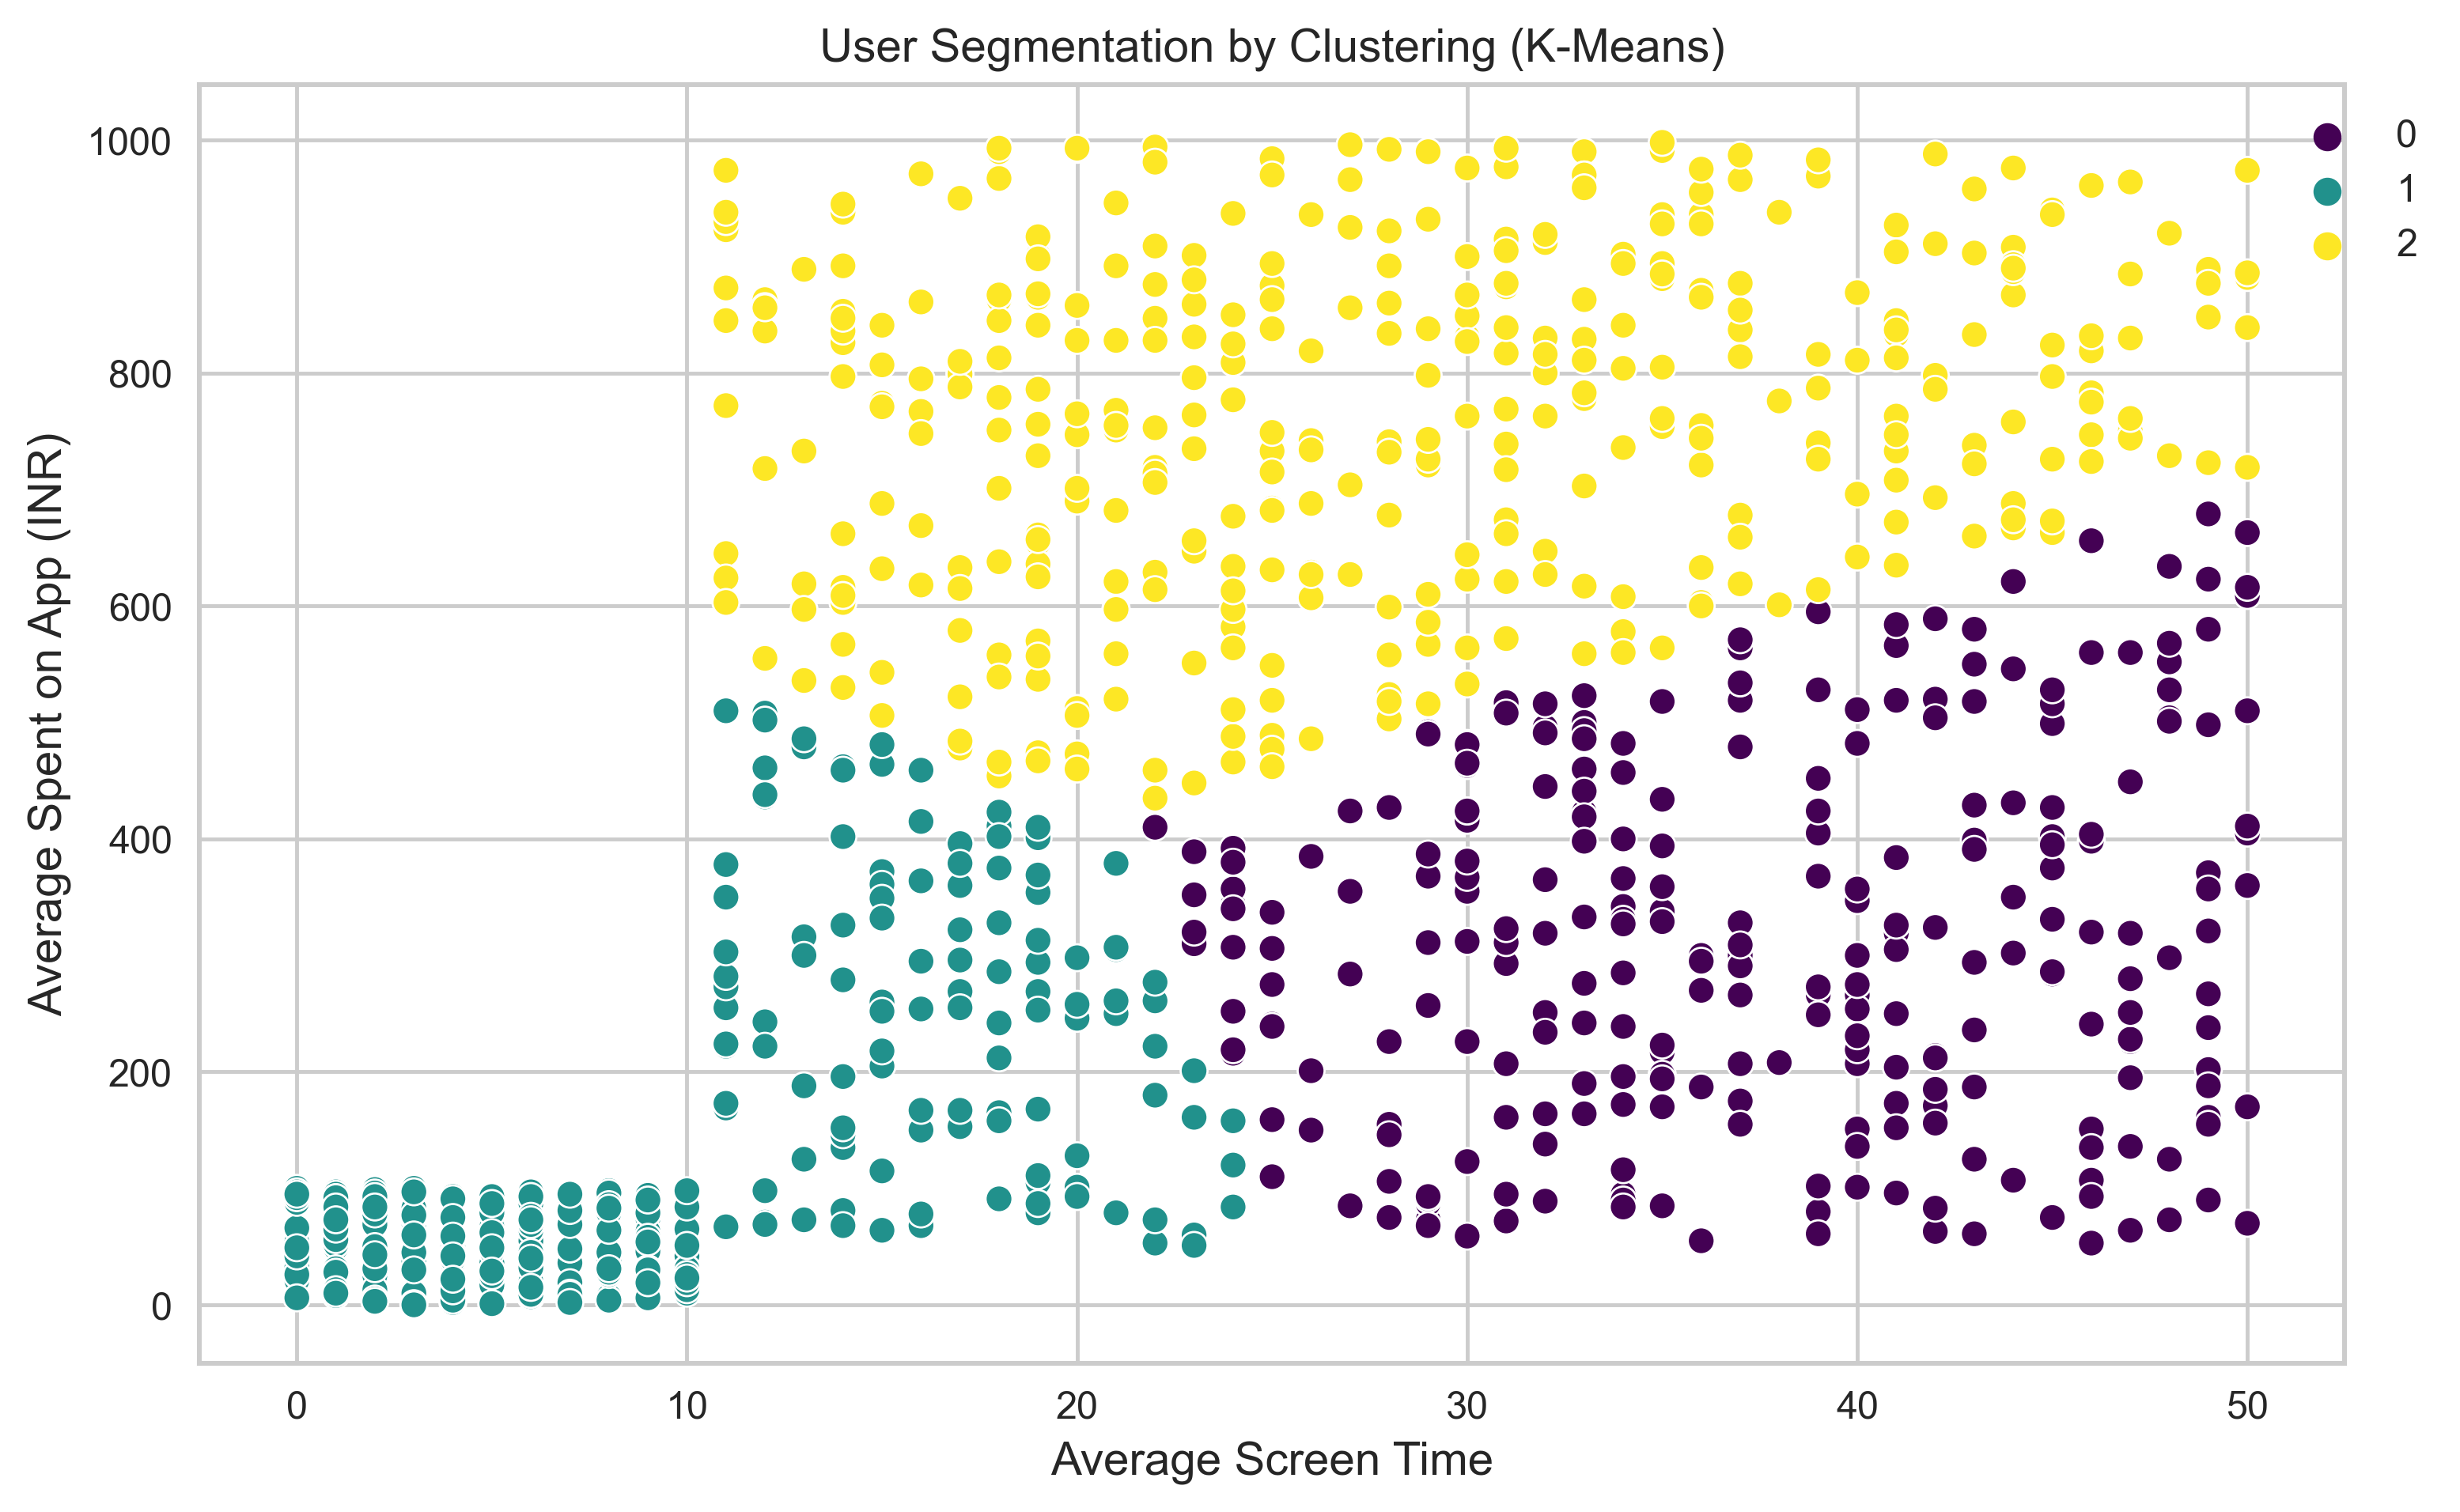

In [25]:
# Visualize the clusters
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x='Average Screen Time', y='Average Spent on App (INR)', hue='Cluster_user_engangment', data=df, palette='viridis')
ax.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.5, fontsize='small')
plt.title('User Segmentation by Clustering (K-Means)')
plt.xlabel('Average Screen Time')
plt.ylabel('Average Spent on App (INR)')
plt.show()

In [26]:
df.groupby('Cluster_user_engangment').agg('mean')

userid  Average Screen Time  \
Cluster_user_engangment                                     
0                        1496.707581            37.411552   
1                        1498.276276             9.084084   
2                        1503.820051            28.221080   

                         Average Spent on App (INR)  Left Review   Ratings  \
Cluster_user_engangment                                                      
0                                        315.036101     0.498195  7.689531   
1                                        123.678679     0.504505  4.297297   
2                                        759.745501     0.491003  7.573265   

                         New Password Request  Last Visited Minutes  
Cluster_user_engangment                                              
0                                    4.494585           2579.559567  
1                                    5.915916          10123.315315  
2                                    4.426735           2622.586118

### Clusters
- **LOW USAGE LOW SPENDING** - CLUSTER 1
- **HIGH USAGE HIGH SPENDING** - CLUSTER 2
- **MODERATE USAGE MODERATE SPENDING** - CLUSTER 0

**The scatter plot effectively illustrates two distinct clusters of users, categorized by their 'Average Screen Time' and 'Last Visited Minutes.' One cluster appears to consist of users displaying higher engagement, evident from both elevated screen time and last visited minutes. Conversely, the second cluster represents users with lower engagement.**

**Cluster Interpretation:**
- Users belonging to the 'High Engagement' cluster are likely more active and engaged with the app, as indicated by their extended screen time and frequent visits.

- Users in the 'Low Engagement' cluster may exhibit less activity or sporadic app usage, suggested by lower screen time and less frequent visits.







## User Segmentation to find app user's retention, or churn

In [27]:
# Select relevant features for clustering
features = df[["Average Screen Time", "Left Review", "Ratings", "Last Visited Minutes", "Average Spent on App (INR)", "New Password Request"]]


In [28]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [29]:
# Based on the Elbow Method, choose the optimal number of clusters
optimal_clusters = 2

# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['Cluster_retention'] = kmeans.fit_predict(features_scaled)


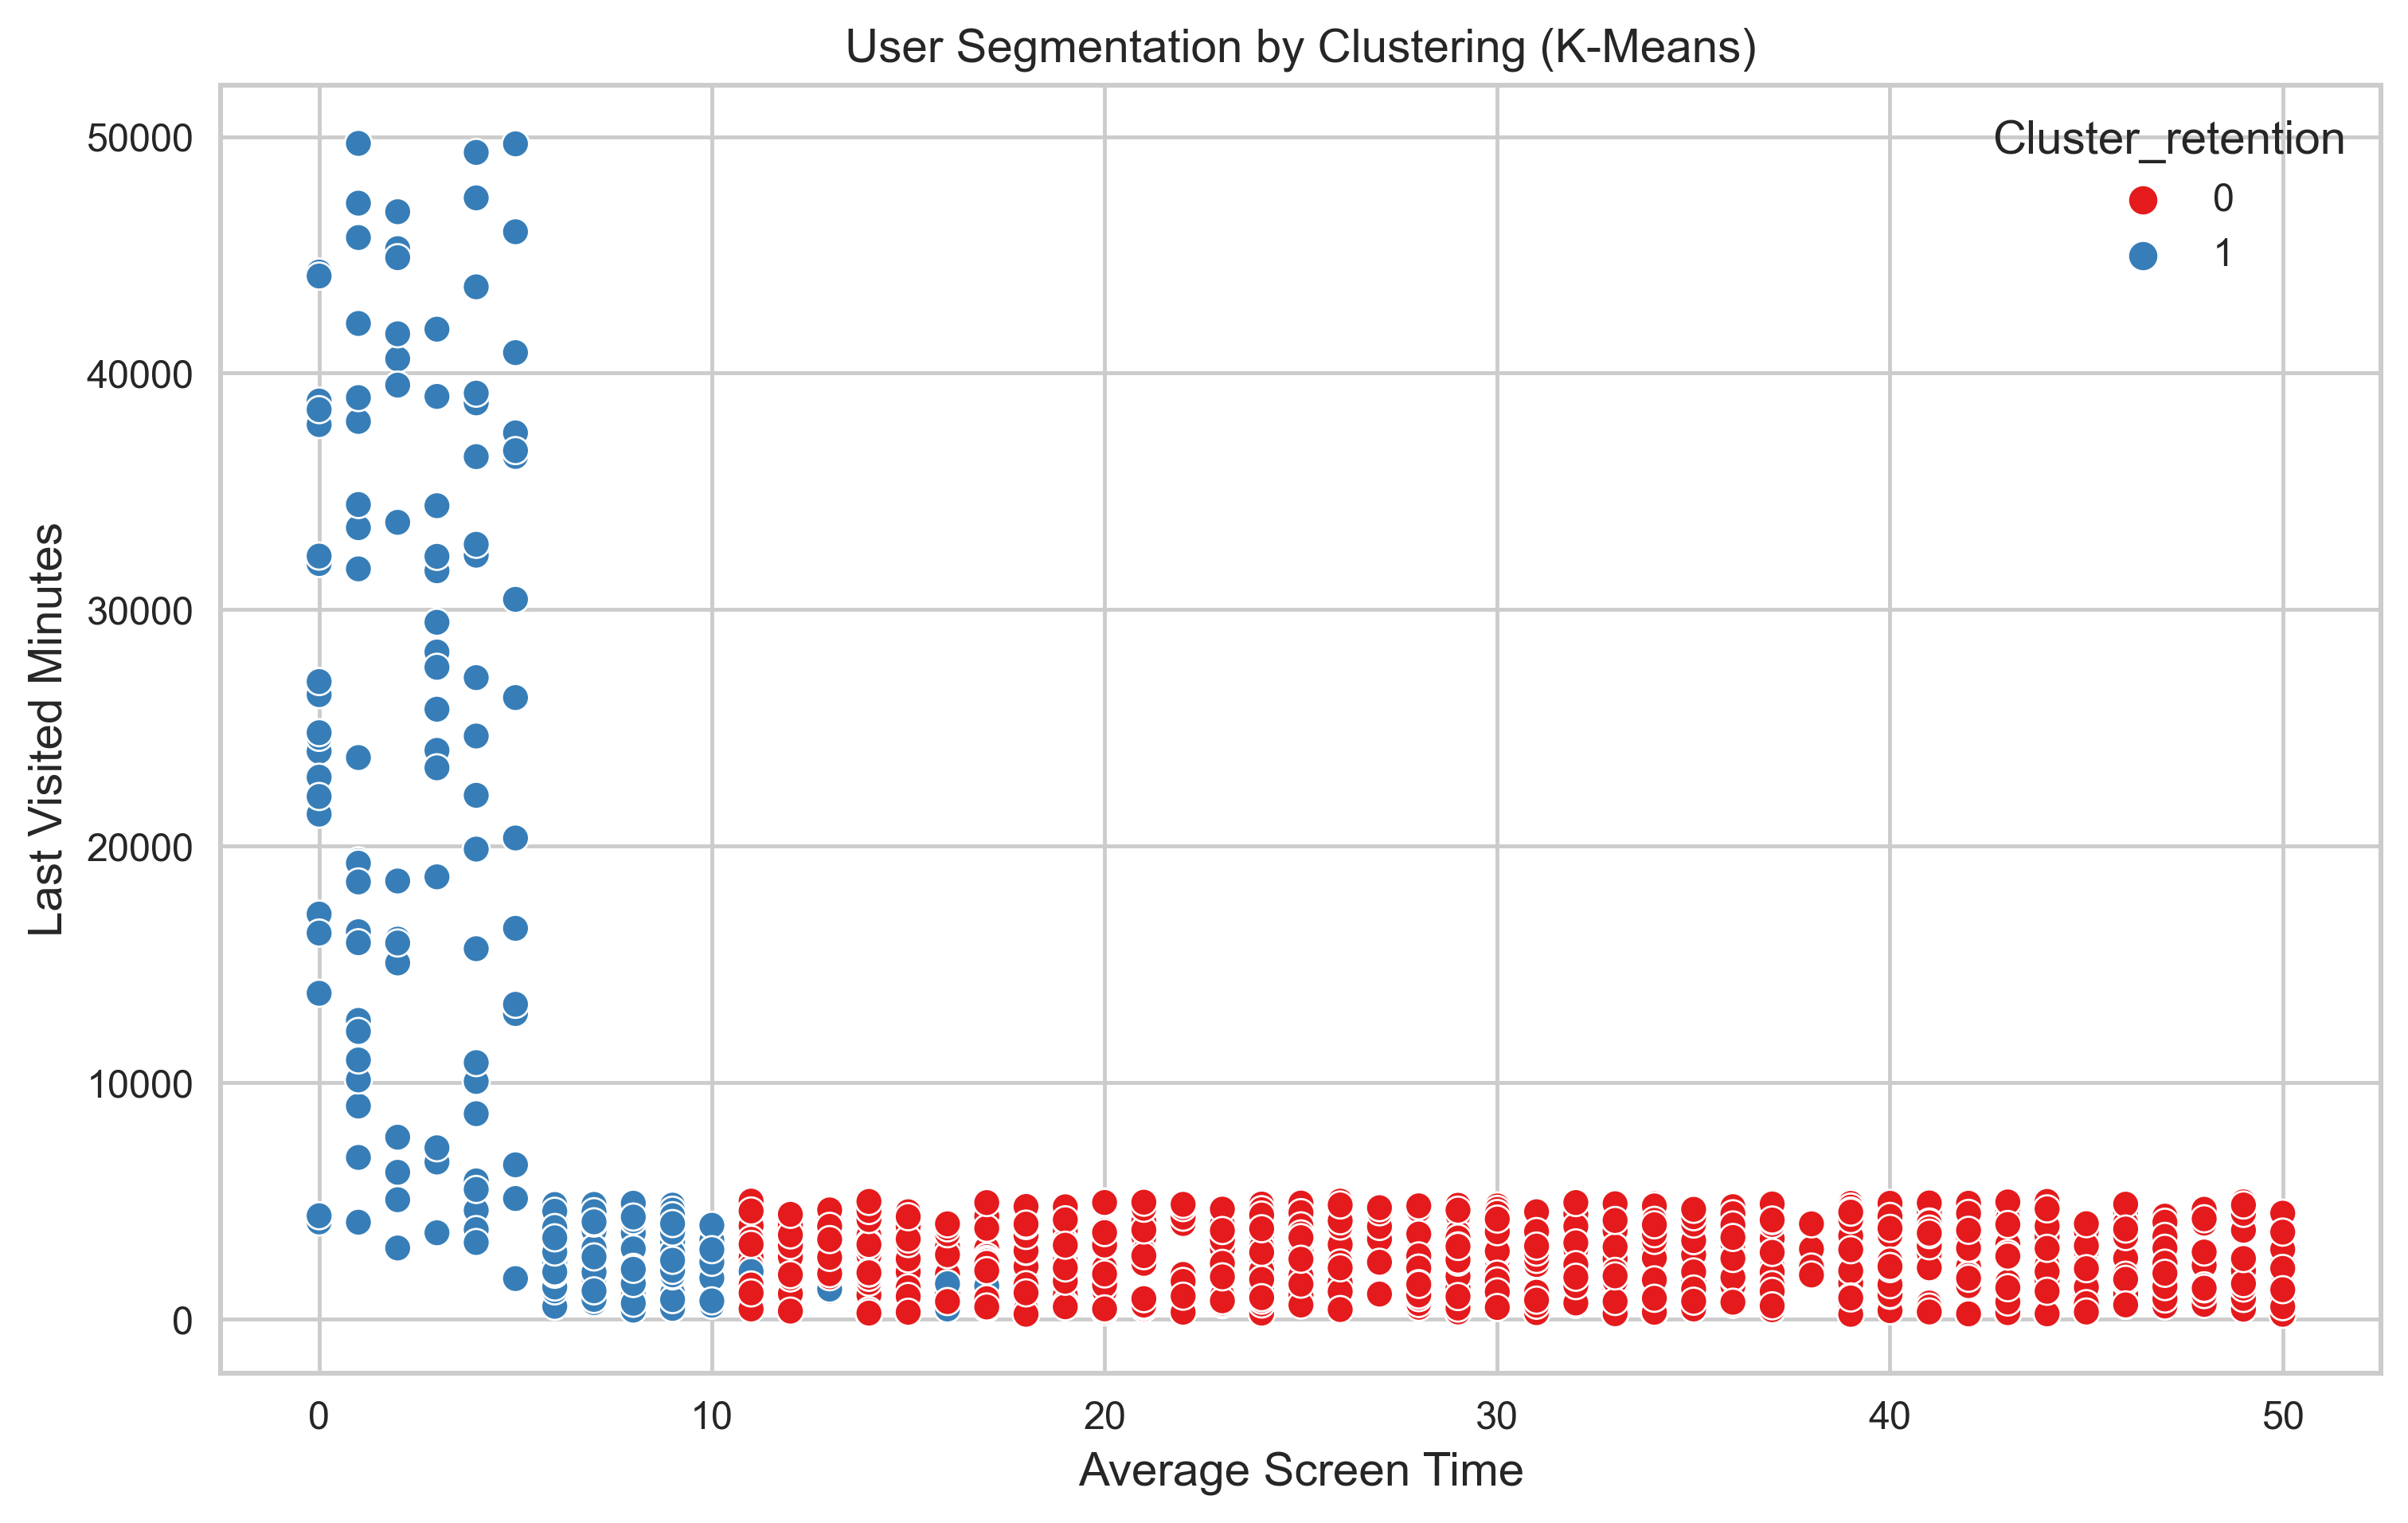

In [30]:
# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Average Screen Time', y='Last Visited Minutes', hue='Cluster_retention', data=df, palette='Set1')
plt.title('User Segmentation by Clustering (K-Means)')
plt.xlabel('Average Screen Time')
plt.ylabel('Last Visited Minutes')
plt.show()


In [31]:
df.groupby('Cluster_retention').agg('mean')

userid  Average Screen Time  \
Cluster_retention                                     
0                  1497.301669            29.811297   
1                  1509.554545             5.195455   

                   Average Spent on App (INR)  Left Review   Ratings  \
Cluster_retention                                                      
0                                  529.181001     0.491656  7.636714   
1                                   53.450000     0.518182  2.536364   

                   New Password Request  Last Visited Minutes  \
Cluster_retention                                               
0                              4.495507           2569.136072   
1                              6.522727          14111.050000   

                   Cluster_user_engangment  
Cluster_retention                           
0                                 1.143774  
1                                 1.000000

In [32]:
df["Cluster_retention"].value_counts()

0    779
1    220
Name: Cluster_retention, dtype: int64

**The scatter plot effectively displays users categorized into two clusters based on 'Average Screen Time' and 'Last Visited Minutes.**

**Cluster Interpretation:**
- **Cluster 0: Retained Users**
- **Cluster 1: Lost Users**

User Behavior Analysis:

Retained Users: This cluster comprises users who demonstrate ongoing engagement with the app, characterized by a relatively higher average screen time and last visited minutes.

Lost Users: Users in this cluster exhibit lower engagement metrics, suggesting potential disinterest or abandonment of the app.







In [33]:
# Assign final names to the clusters based on interpretation
df['Cluster_retention'] = df['Cluster_retention'].map({0: 'Retained Users', 1: 'Lost Users'})


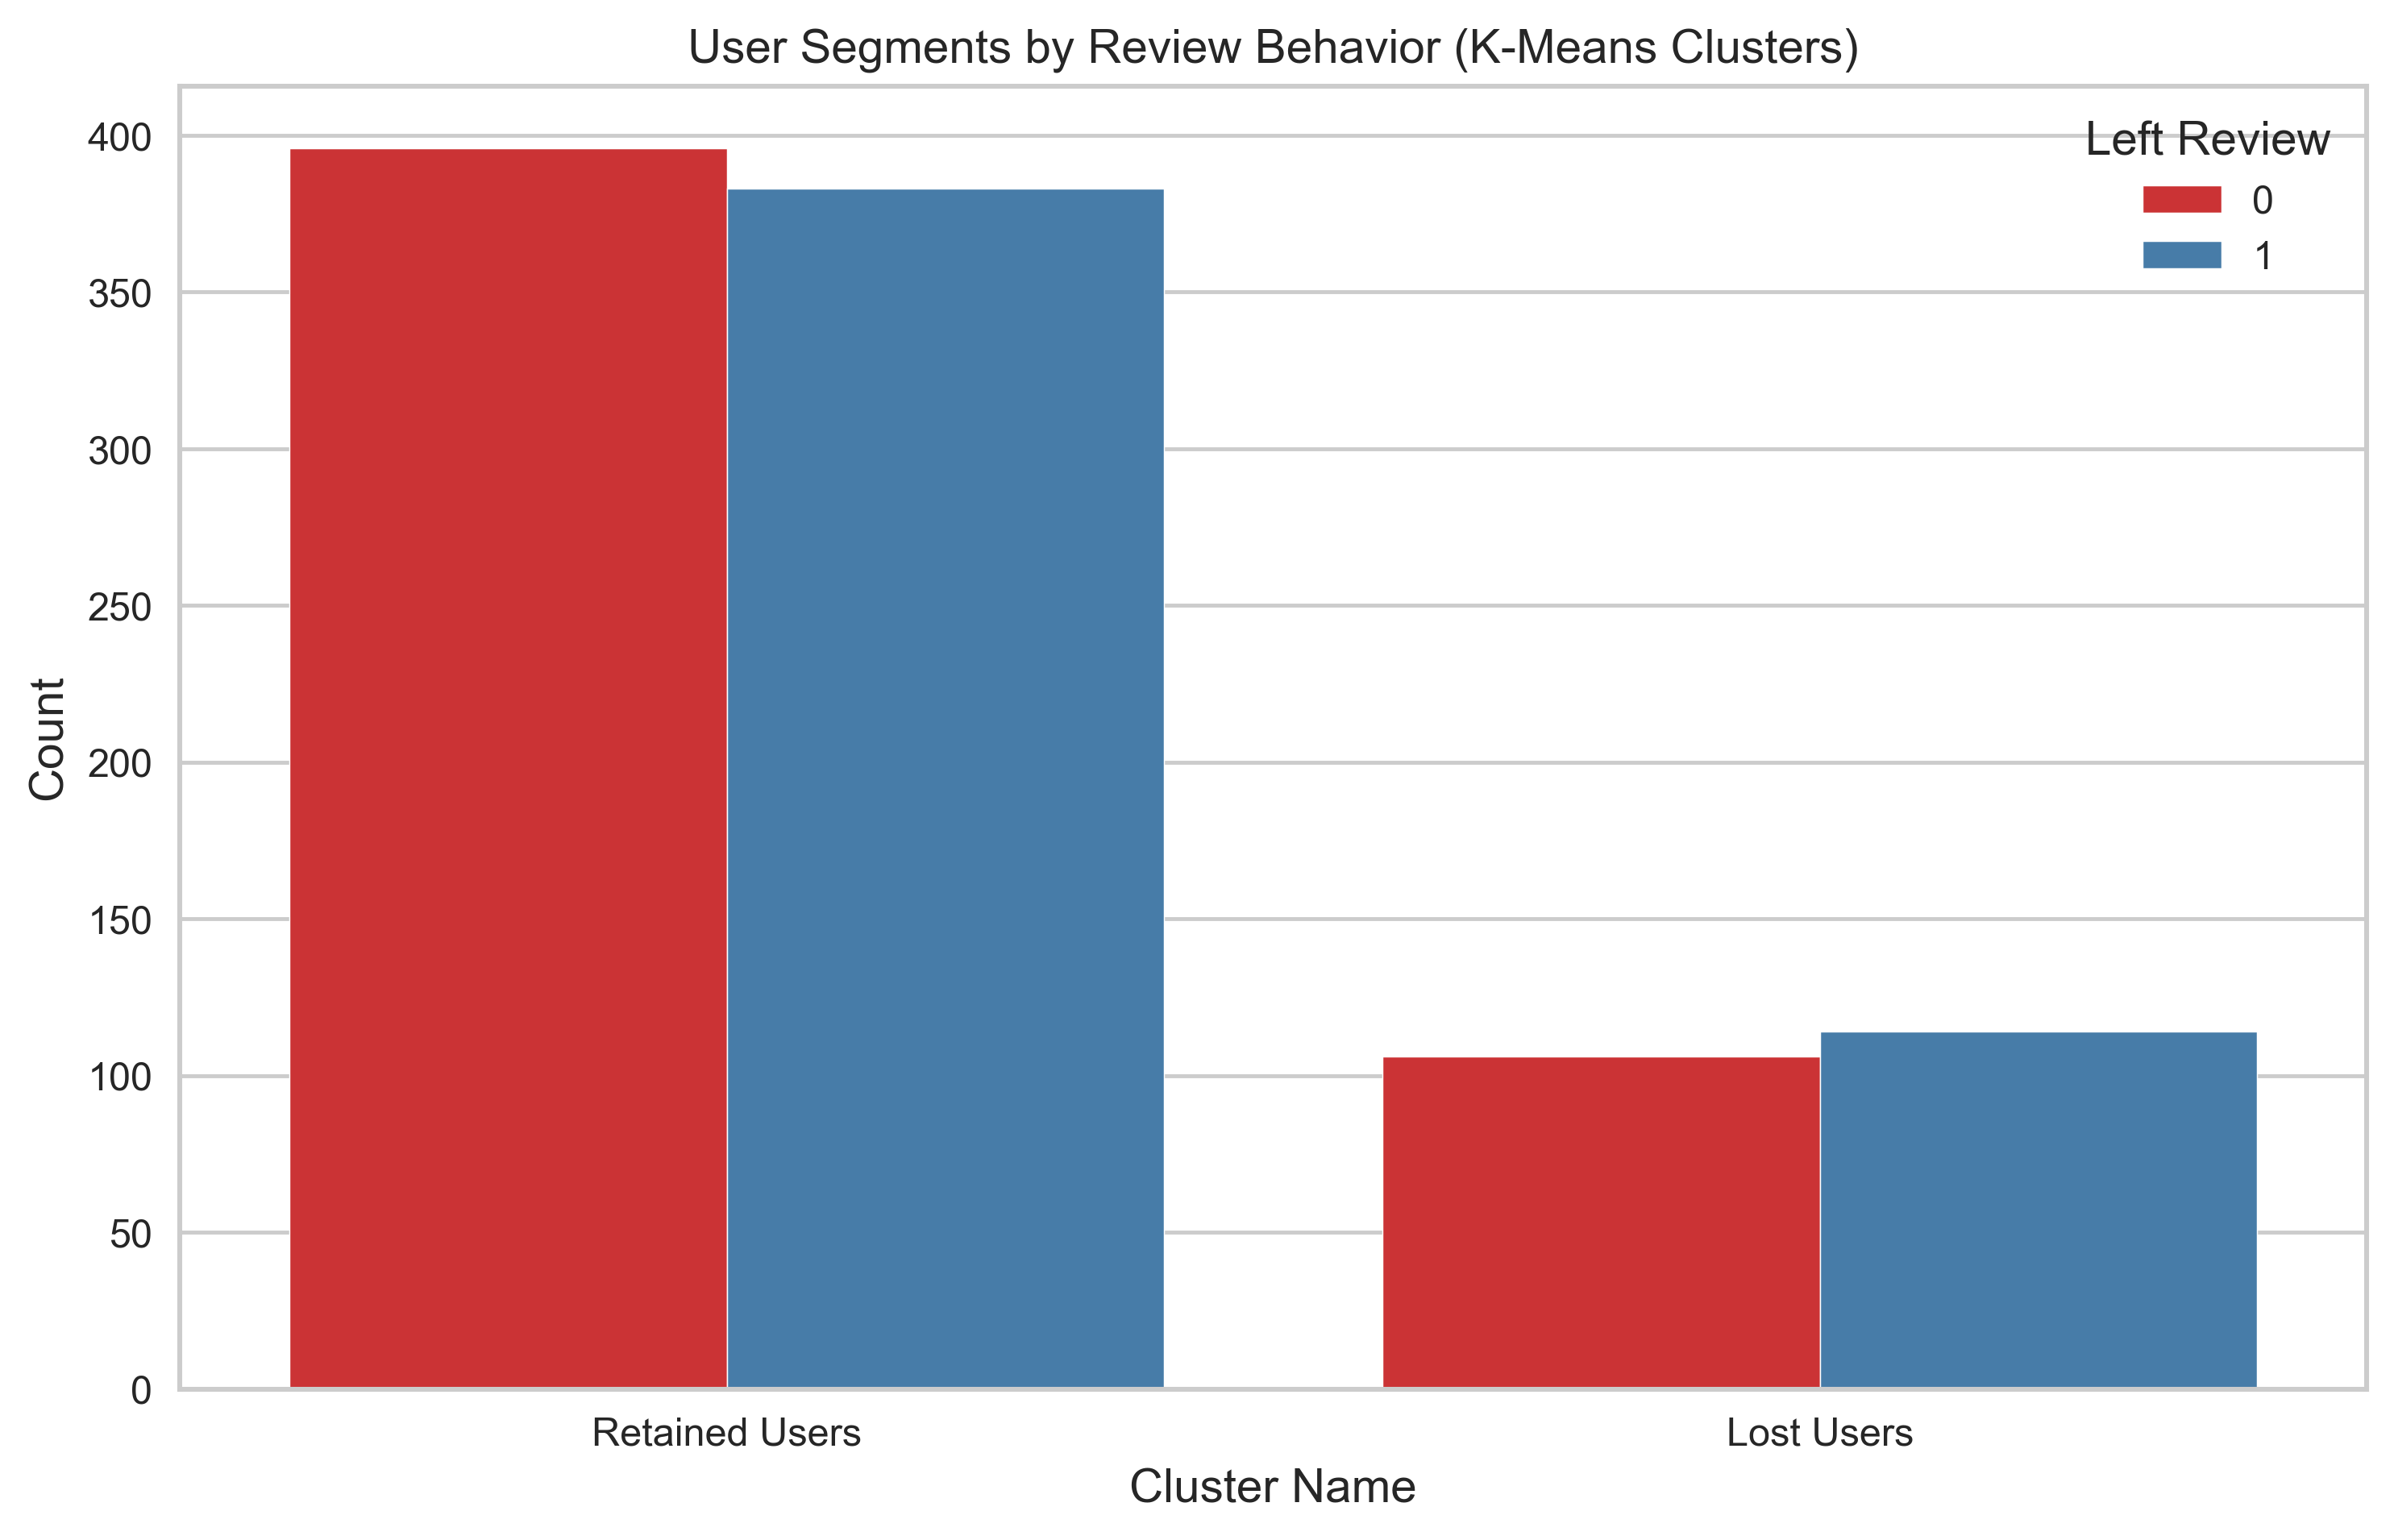

In [34]:
# Explore user segments by review behavior
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster_retention', hue='Left Review', data=df,palette='Set1')
plt.title('User Segments by Review Behavior (K-Means Clusters)')
plt.xlabel('Cluster Name')
plt.ylabel('Count')
plt.legend(title='Left Review', loc='upper right')
plt.show()


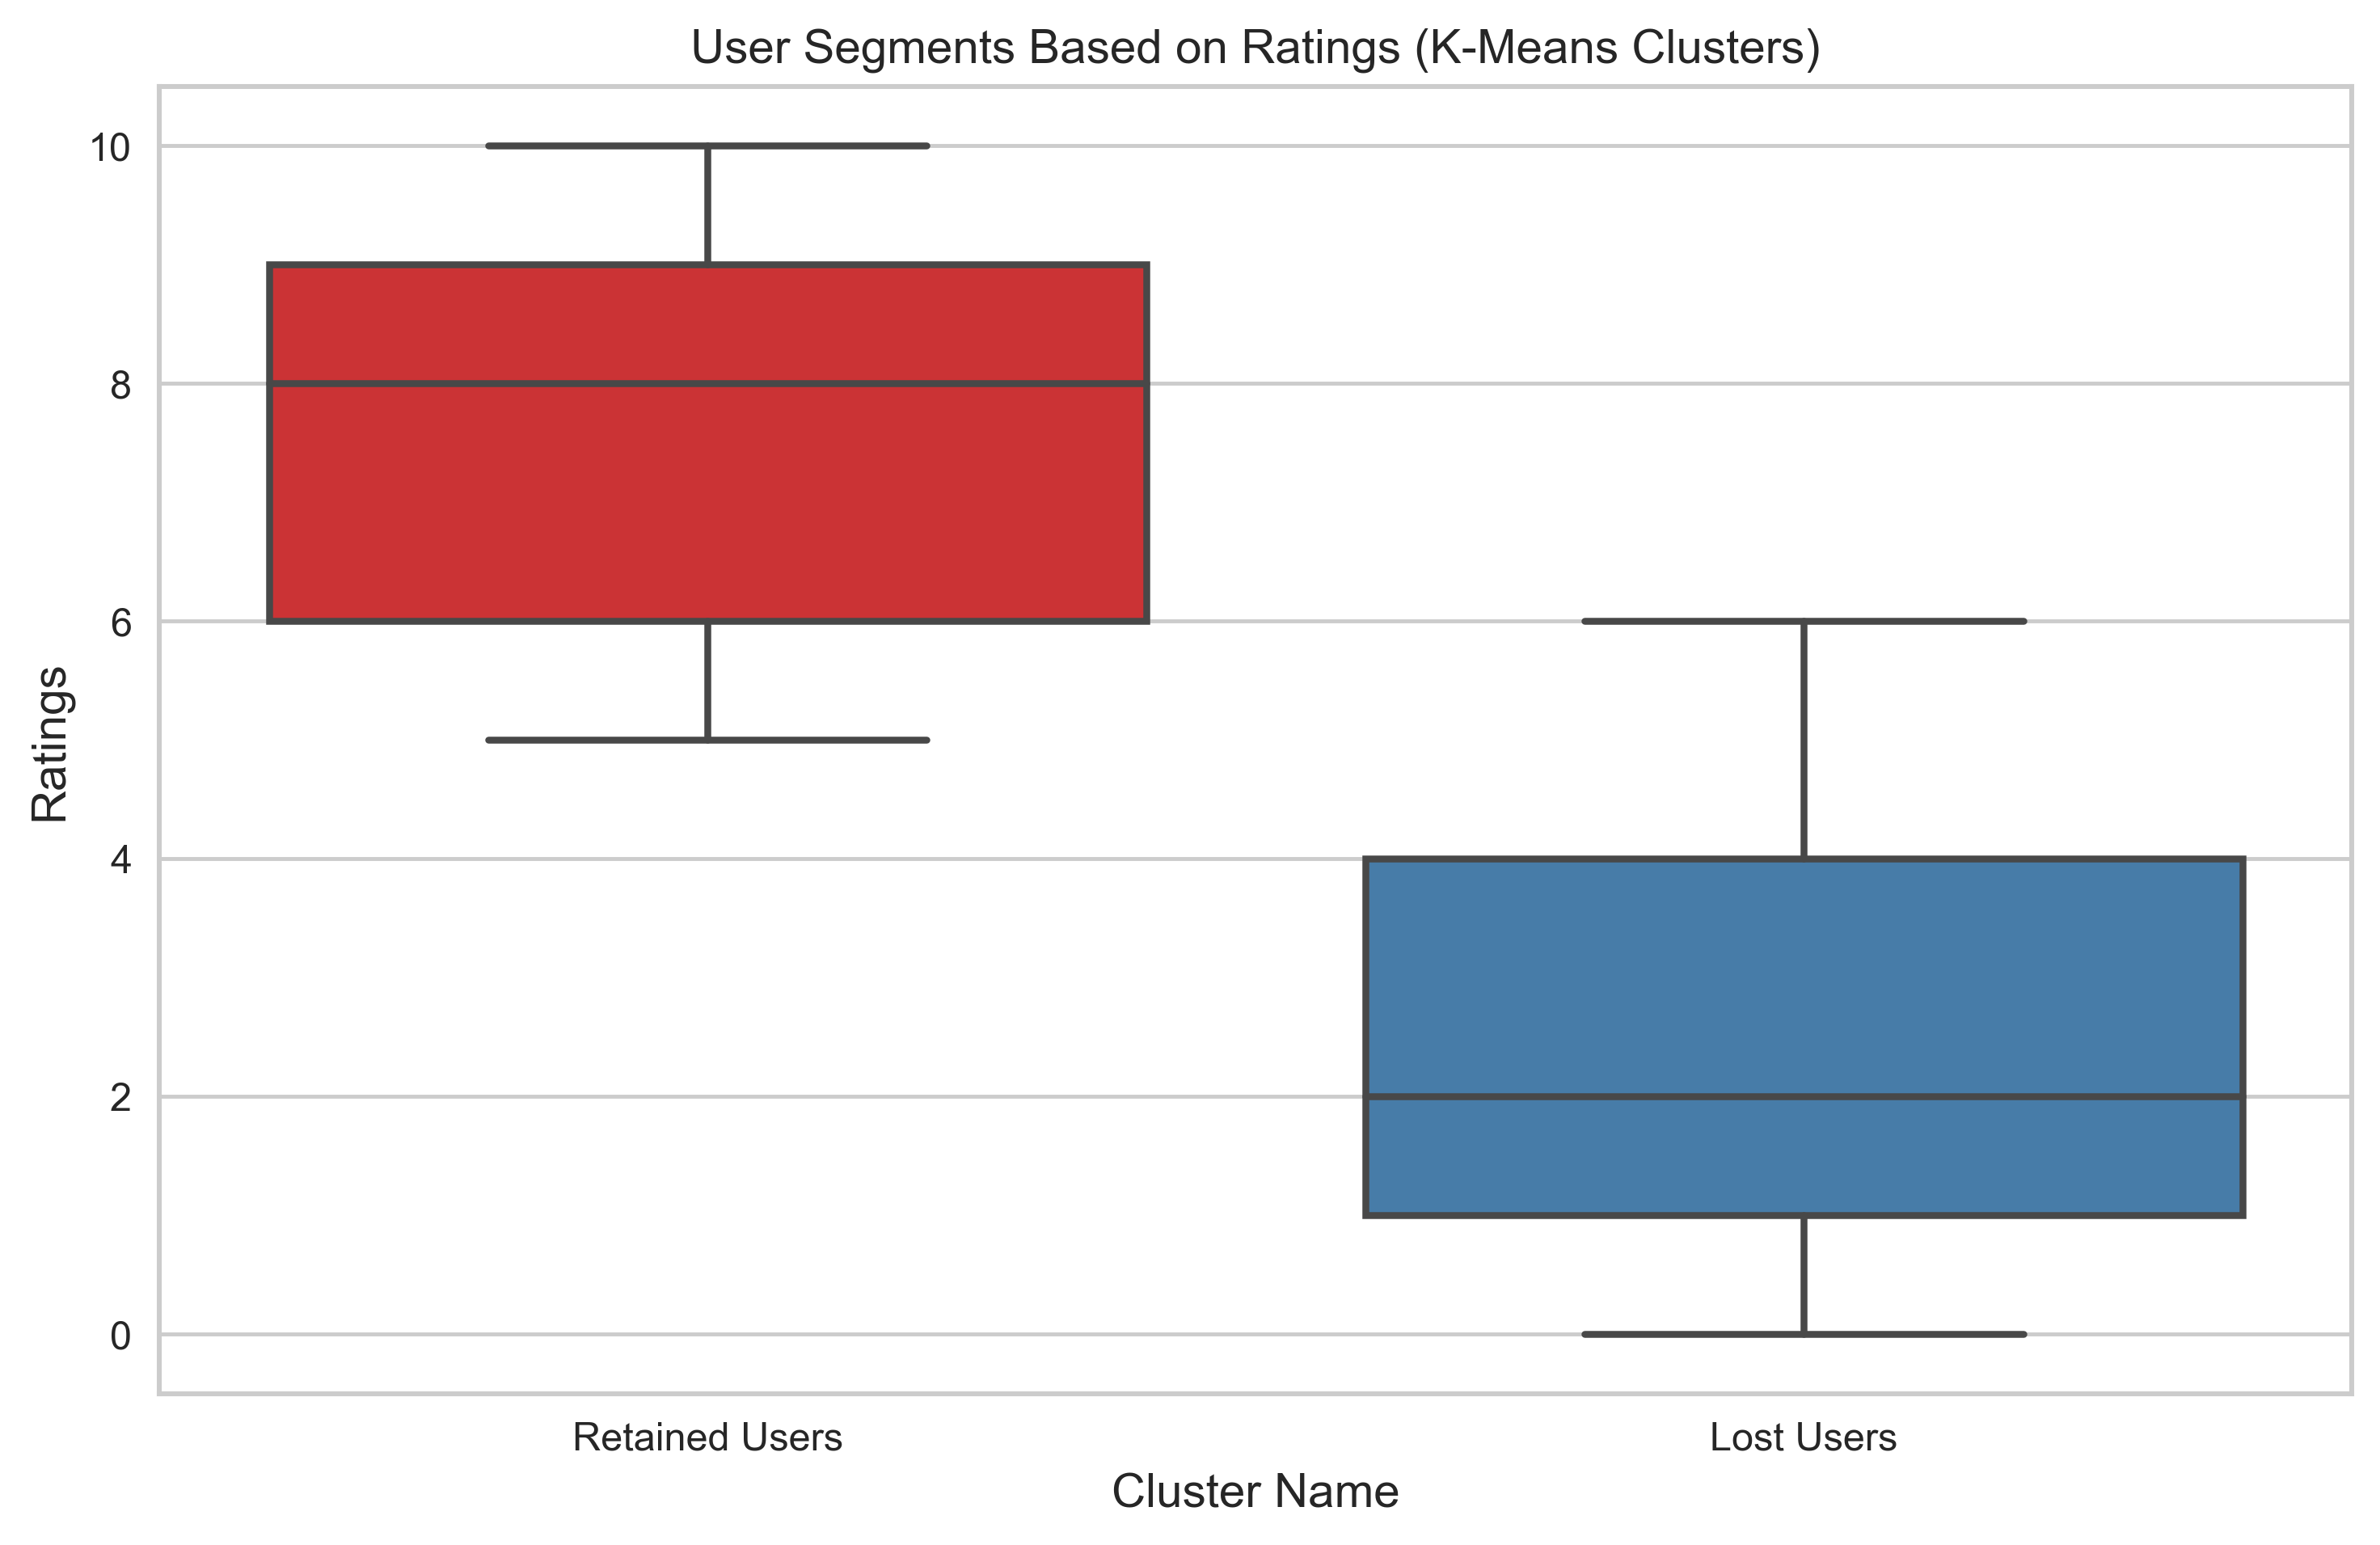

In [37]:
# Segment users based on ratings
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster_retention', y='Ratings', data=df,palette='Set1')
plt.title('User Segments Based on Ratings (K-Means Clusters)')
plt.xlabel('Cluster Name')
plt.ylabel('Ratings')
plt.show()


**Review and Rating Analysis:**
The countplot provides insight into the number of users in each cluster who have left a review. Additionally, the boxplot visually represents the distribution of ratings within each cluster, offering a comprehensive view of the rating patterns among the user segments.

# Overall Conclusions & finding

**Behavior Analysis:**
Users with less average screen time are more likely to uninstall the app, and their average screen time is typically less than 5 minutes.
Users with elevated screen time tend to provide higher ratings, while those with lower screen time are more likely to give below-average ratings and uninstall the app.
Users who spent around 100 rupees but uninstalled the app usually gave a maximum rating of 5. In contrast, users with higher spending tend to give higher ratings.

**User Status Comparison:**
Users with the app installed exhibit higher screen time and spending compared to those without the app.
Average spending is notably higher among users with the app installed.
Ratings provided by users with the app installed are significantly higher compared to users without the app.
The time of the last visit is longer among users without the app installed.

**User Segmentation to Identify Retention or Churn:**
In conclusion, the User Segmentation to Identify Retention or Churn reveals valuable insights into the diverse behaviors of app users. The clustering analysis effectively categorizes users into two distinct clusters, namely 'Retained Users' and 'Lost Users.' Retained Users, characterized by higher average screen time and last visited minutes, showcase ongoing engagement and loyalty to the app. On the other hand, Lost Users exhibit lower engagement metrics, indicating a potential decline in interest and an increased likelihood of uninstalling the app. This segmentation provides a strategic advantage, enabling targeted efforts to retain users and mitigate churn by tailoring interventions to the specific needs of each user group.

**User Segmentation based on Screen Time & Spending Behavior:**
The User Segmentation based on Screen Time & Spending Behavior offers a nuanced understanding of user engagement patterns. Through K-means clustering, users are categorized into clusters representing 'Low Usage, Low Spending,' 'Moderate Usage, Moderate Spending,' and 'High Usage, High Spending.' This segmentation not only reflects the diversity in user behaviors but also unveils meaningful distinctions between high and low engagement. Users in the 'High Usage, High Spending' cluster emerge as the most engaged and valuable segment, providing an opportunity for targeted marketing and personalized experiences. This segmentation strategy empowers app developers and marketers to tailor their approaches, addressing the unique needs and preferences of each user segment.

**Suggestions for Further Improvement:**

Feature Engineering: Explore additional features or derive new ones that might provide deeper insights into user behavior. Consider factors like session frequency, specific in-app activities, or user demographics.

Temporal Analysis: Incorporate time-based analysis to understand how user behavior evolves over time. This could include trends in engagement, spending, and uninstallation rates on a monthly or quarterly basis.

Advanced Clustering Techniques:Experiment with other clustering algorithms (e.g., hierarchical clustering, DBSCAN) to see if different techniques yield more meaningful user segments.

Predictive Modeling: Move beyond descriptive analysis and explore predictive modeling to anticipate user behaviors. Consider using machine learning models to predict the likelihood of churn or engagement based on historical data.